# 03 EDA ON PRICE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # optional, nice for advanced EDA

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor  # example regressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from shapely.geometry import Point


import sys

from pathlib import Path 




In [2]:
# Project root & data paths
project_root = Path().resolve().parent
df_pre_path = project_root / "data" / "interim" / "data_preprocessed.parquet"
df_pre = pd.read_parquet(df_pre_path)

src_path = project_root / "src"
sys.path.append(str(src_path))


In [3]:

listings_extended_path = project_root / "data" / "raw" / "listings_extended.csv"

# Load the data
df_raw_listings_extended = pd.read_csv(listings_extended_path)
df_raw = df_raw_listings_extended.copy()  # Work on a copy to keep the original data intact

In [4]:
df_raw['host_since'] = pd.to_datetime(df_raw['host_since'], errors='coerce')
df_raw['first_review'] = pd.to_datetime(df_raw['first_review'], errors='coerce')

In [5]:
df_raw['last_scraped']

0        2024-09-17
1        2024-09-17
2        2024-09-17
3        2024-09-17
4        2024-09-18
            ...    
23700    2024-09-17
23701    2024-09-17
23702    2024-09-17
23703    2024-09-17
23704    2024-09-17
Name: last_scraped, Length: 23705, dtype: object

In [6]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df_raw.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df_raw.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 13 August 2008, and the most recent joined on 15 September 2024.


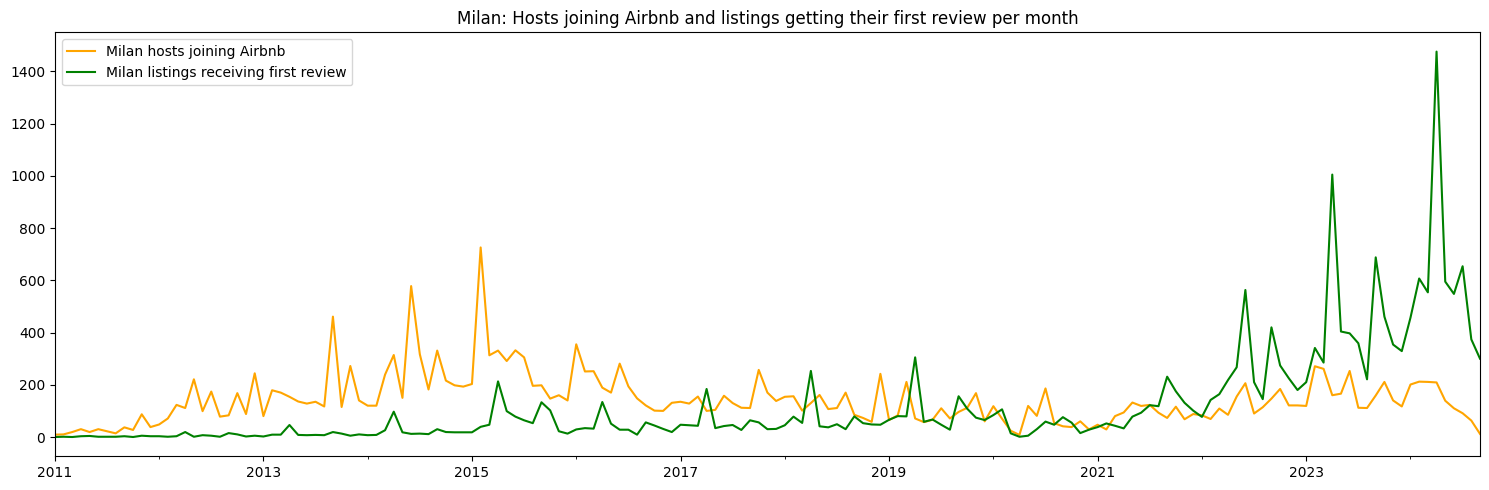

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

df_raw.set_index('host_since').resample('MS').size().plot(
    label='Milan hosts joining Airbnb', color='orange'
)
df_raw.set_index('first_review').resample('MS').size().plot(
    label='Milan listings receiving first review', color='green'
)

plt.title('Milan: Hosts joining Airbnb and listings getting their first review per month')
plt.legend()
plt.xlim('2011-01-01', '2024-09-17')  # Updated range from 2010 to 2025
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

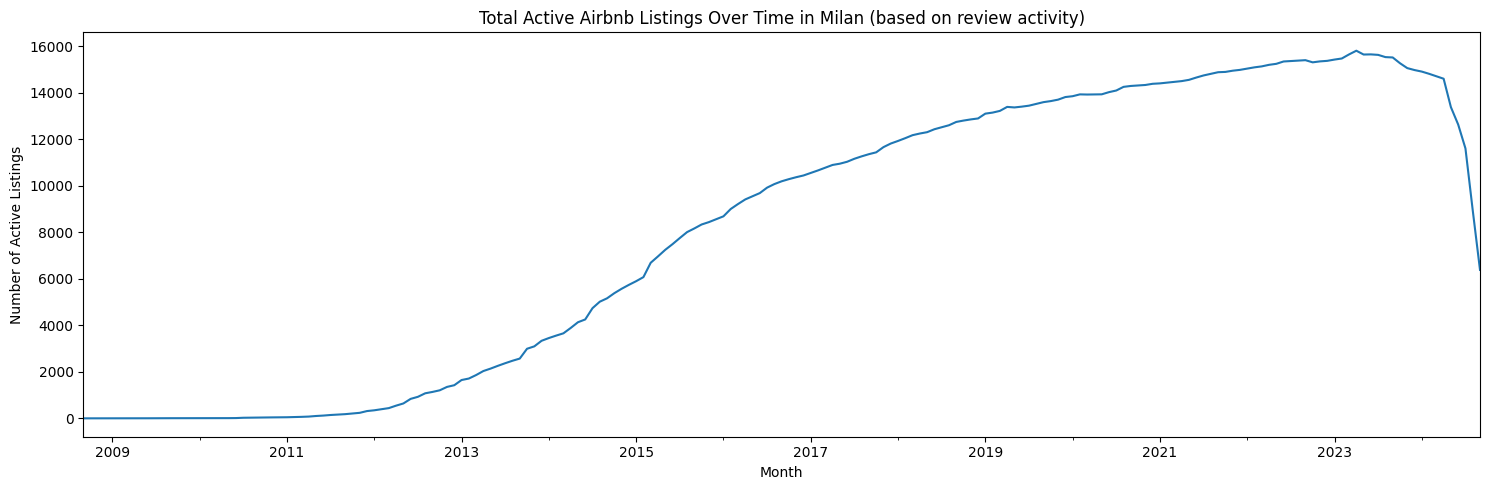

In [8]:
# Convert review dates
df_raw['first_review'] = pd.to_datetime(df_raw['first_review'], errors='coerce')
df_raw['last_review'] = pd.to_datetime(df_raw['last_review'], errors='coerce')

# Create a copy with only listings that have a last_review date
df_active = df_raw[['id', 'host_since', 'last_review']].dropna(subset=['last_review']).copy()

# For each listing, we assume it's "active" from host_since to last_review
# We’ll resample monthly and count how many listings were active

# Step 1: For each row, generate the months during which the listing was active
from pandas.tseries.offsets import MonthBegin

df_active['host_since'] = pd.to_datetime(df_active['host_since'])
df_active['last_review'] = pd.to_datetime(df_active['last_review'])

active_periods = []

for _, row in df_active.iterrows():
    active_months = pd.date_range(row['host_since'], row['last_review'], freq='MS')
    active_periods.extend(active_months)

# Step 2: Count how many listings were active each month
import pandas as pd
active_month_series = pd.Series(active_periods)
active_counts = active_month_series.value_counts().sort_index()

# Step 3: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
active_counts.plot()
plt.title("Total Active Airbnb Listings Over Time in Milan (based on review activity)")
plt.ylabel("Number of Active Listings")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

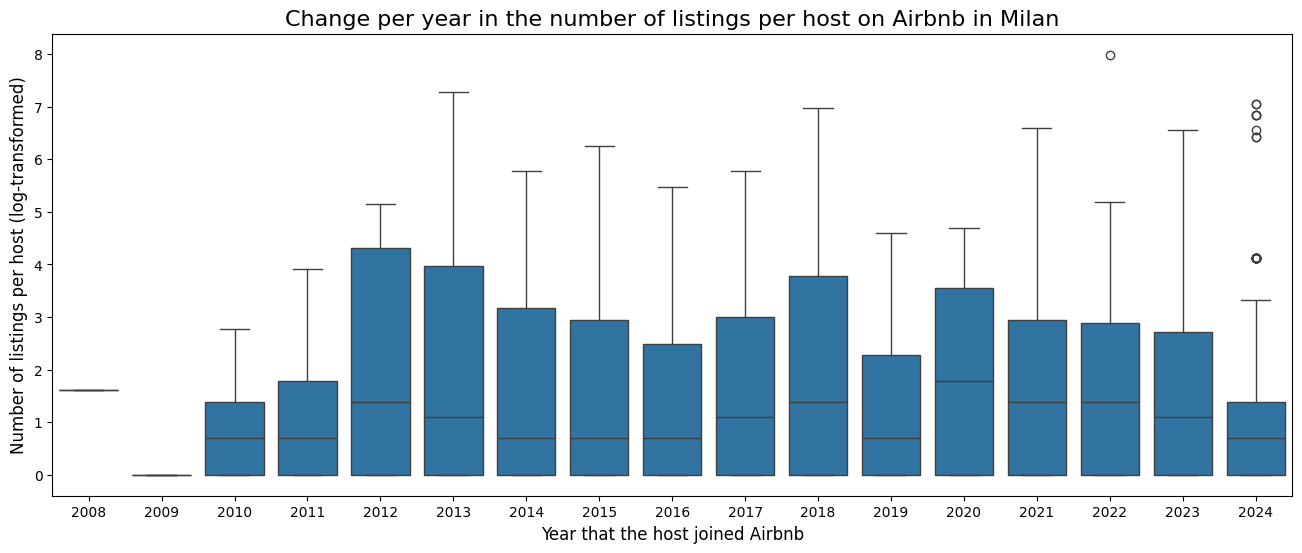

In [9]:
plt.figure(figsize=(16,6))
sns.boxplot(x=df_raw.host_since.dt.year, y=np.log(df_raw.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Milan', fontsize=16)
plt.show()

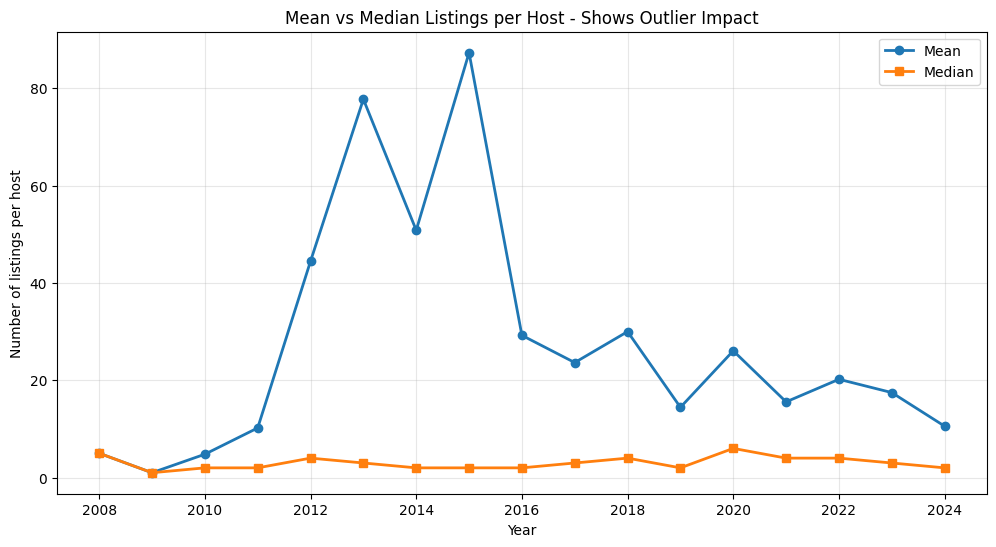

In [10]:
yearly_stats = df_raw.groupby(df_raw.host_since.dt.year)['host_listings_count'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_stats['host_since'], yearly_stats['mean'], marker='o', label='Mean', linewidth=2)
plt.plot(yearly_stats['host_since'], yearly_stats['median'], marker='s', label='Median', linewidth=2)
plt.title('Mean vs Median Listings per Host - Shows Outlier Impact')
plt.xlabel('Year')
plt.ylabel('Number of listings per host')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

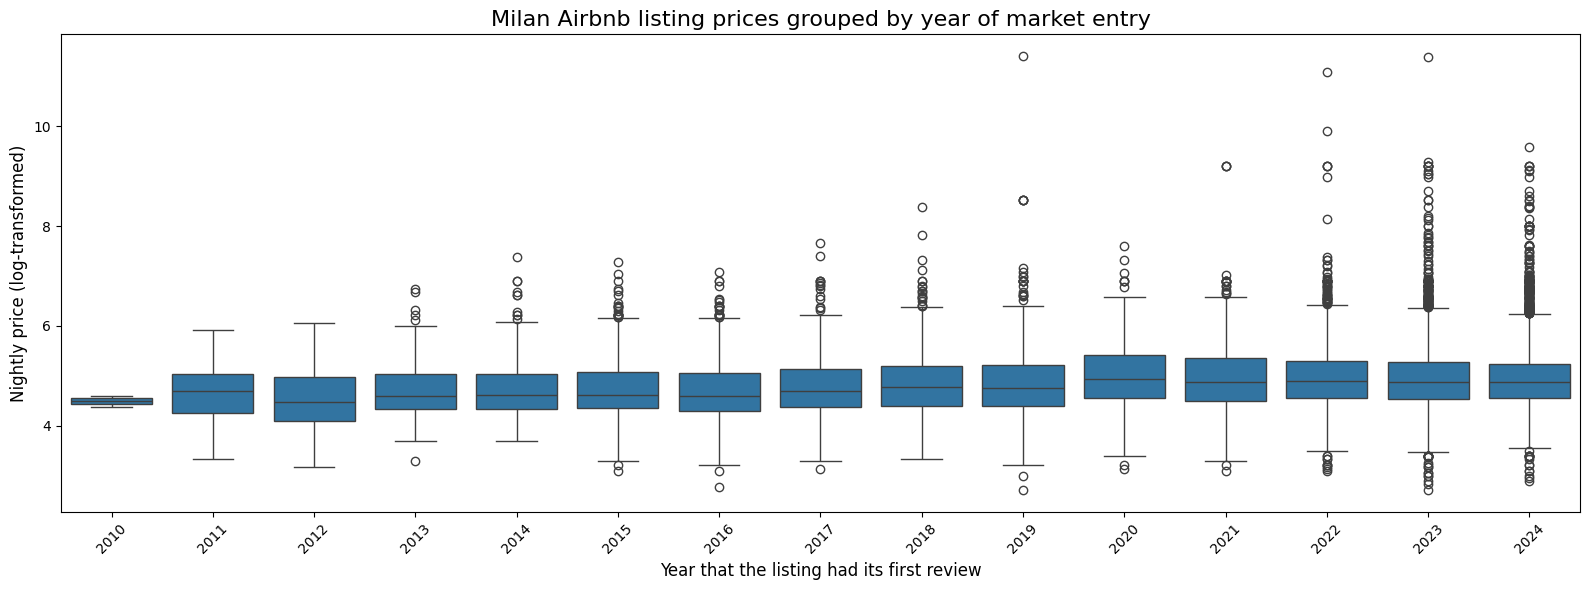

In [11]:
# Create the figure
plt.figure(figsize=(16, 6))

# Convert price to numeric (remove $ signs, commas, etc.) and handle missing values
df_raw['price_numeric'] = pd.to_numeric(df_raw['price'].astype(str).str.replace('[$,]', '', regex=True), errors='coerce')

# Create boxplot with proper syntax - filter out NaN values
valid_data = df_raw.dropna(subset=['price_numeric', 'first_review'])
sns.boxplot(data=valid_data, x=valid_data.first_review.dt.year, y=np.log(valid_data.price_numeric))

# Add labels and title
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title("Milan Airbnb listing prices grouped by year of market entry", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

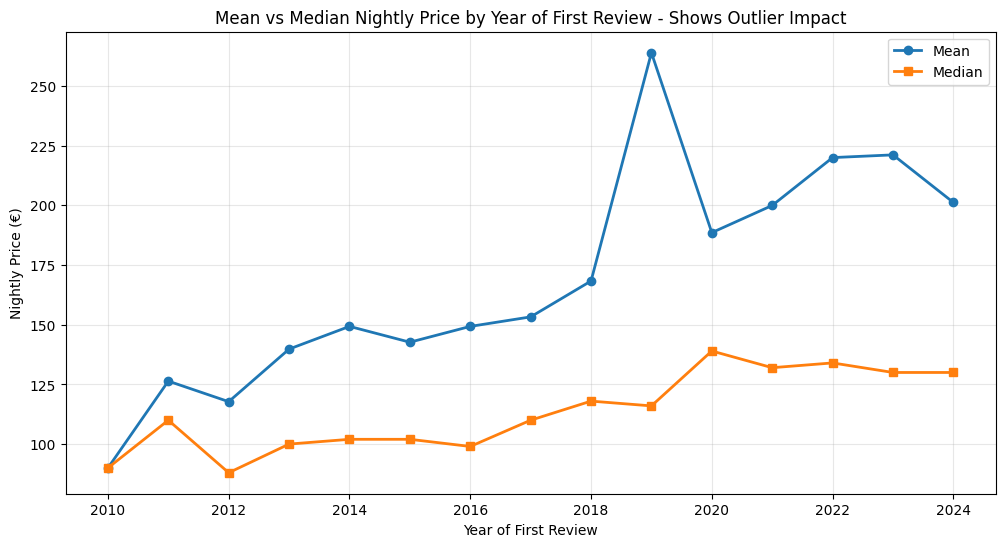

In [12]:
# Group by first review year and calculate mean/median price
yearly_price_stats = df_raw.groupby(df_raw.first_review.dt.year)['price_numeric'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_price_stats['first_review'], yearly_price_stats['mean'], marker='o', label='Mean', linewidth=2)
plt.plot(yearly_price_stats['first_review'], yearly_price_stats['median'], marker='s', label='Median', linewidth=2)
plt.title('Mean vs Median Nightly Price by Year of First Review - Shows Outlier Impact')
plt.xlabel('Year of First Review')
plt.ylabel('Nightly Price (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## What is the overall distribution of prices?


In [13]:
print(f"Nightly advertised prices range from €{min(df_pre.price)} to €{max(df_pre.price)}.")

Nightly advertised prices range from €14.0 to €90000.0.


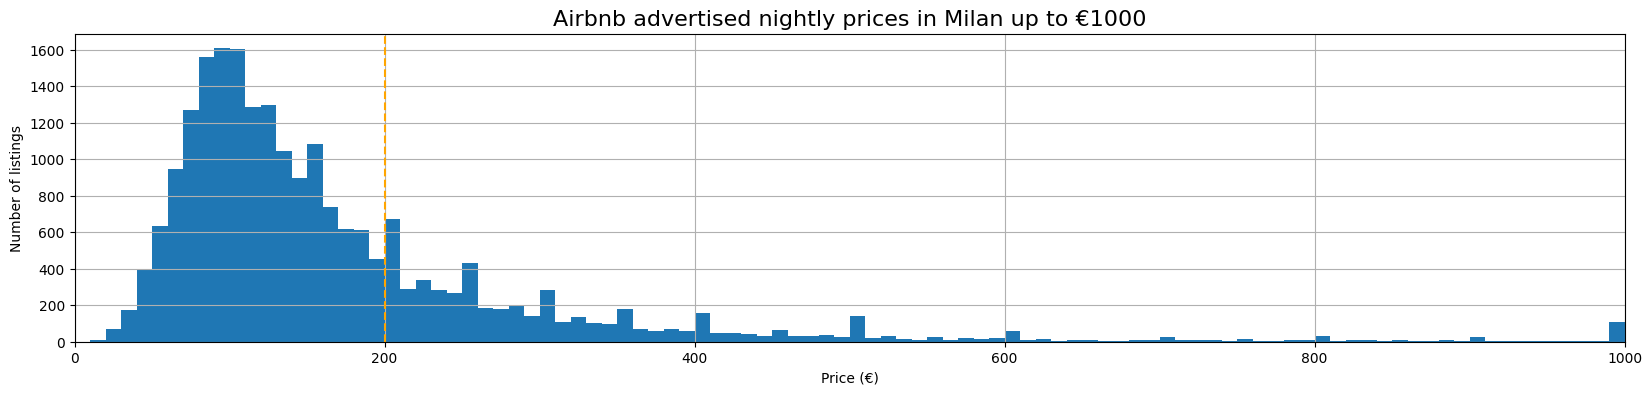

In [14]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df_pre.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Milan up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

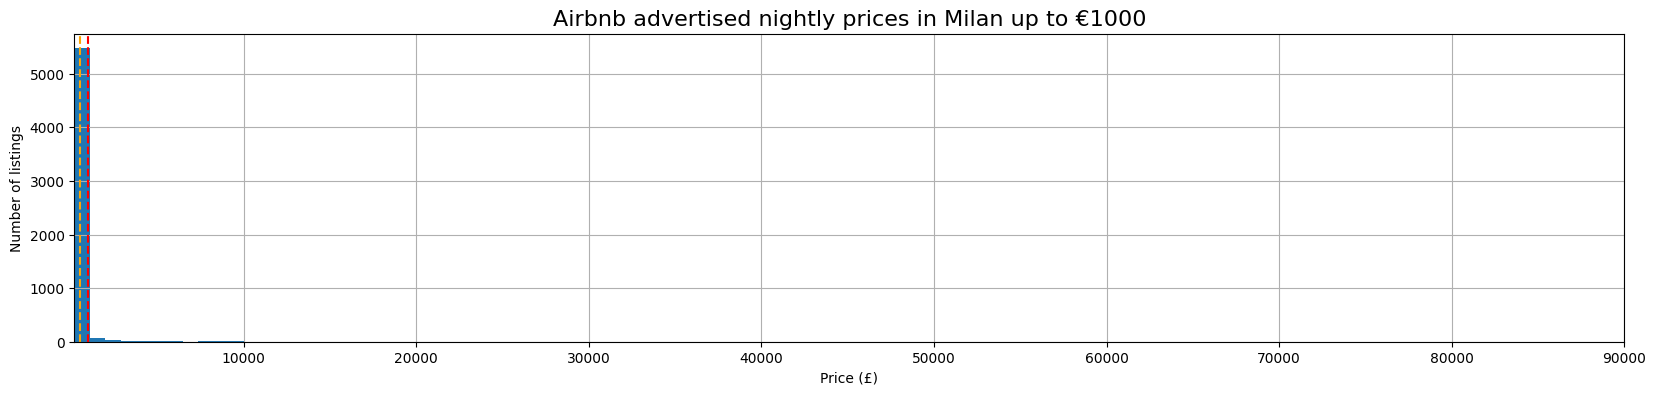

In [15]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df_pre.price.hist(bins=100, range=(200, max(df_pre.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Milan up to €1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [16]:
# Project root & data paths
project_root = Path().resolve().parent
df_path = project_root / "data" / "interim" / "data_preprocessed.parquet"

# Load the data
df = pd.read_parquet(df_path)
df = df.copy()

# Check the structure and first rows
df.info()
df.head()

# Let's look at the shape of the dataset
print("Dataset shape (rows, columns):", df.shape)

# Column names
print("Column names:\n", df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
Index: 21961 entries, 0 to 23704
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            21961 non-null  int64         
 1   last_scraped                                  21961 non-null  datetime64[ns]
 2   host_location                                 21961 non-null  object        
 3   host_is_superhost                             21961 non-null  bool          
 4   host_listings_count                           21961 non-null  int64         
 5   host_total_listings_count                     21961 non-null  int64         
 6   host_identity_verified                        21961 non-null  bool          
 7   neighbourhood_cleansed                        21961 non-null  object        
 8   property_type                                 21961 non-null  object   

### data exploration: Boolean columns

### Boolean Features Value Counts ###

--- host_is_superhost ---
host_is_superhost
False    15699
True      6262
Name: count, dtype: int64


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/3010125009.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X[col], palette="pastel")


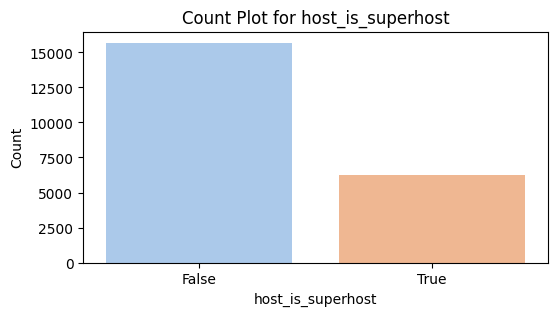


--- host_identity_verified ---
host_identity_verified
True     20698
False     1263
Name: count, dtype: int64


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/3010125009.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X[col], palette="pastel")


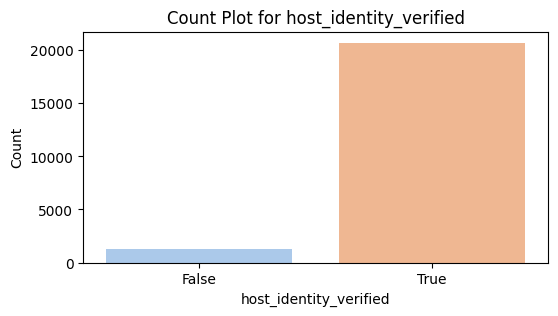


--- host_about_present ---
host_about_present
True     11598
False    10363
Name: count, dtype: int64


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/3010125009.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X[col], palette="pastel")


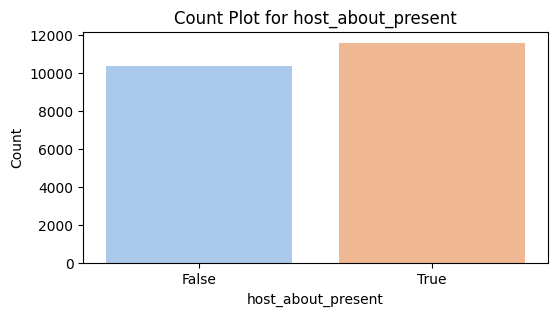


--- neighborhood_overview_present ---
neighborhood_overview_present
True     11497
False    10464
Name: count, dtype: int64


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/3010125009.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=X[col], palette="pastel")


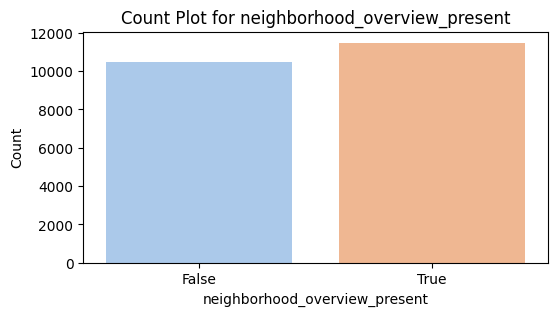

In [17]:
X = df.drop(columns=["price"])
y = df["price"]

bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

if bool_cols:
    print("### Boolean Features Value Counts ###")
    for col in bool_cols:
        print(f"\n--- {col} ---")
        print(X[col].value_counts(dropna=False))

        plt.figure(figsize=(6, 3))
        sns.countplot(x=X[col], palette="pastel")
        plt.title(f"Count Plot for {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

else:
    print("No boolean columns found in the training set.")

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Il dizionario che associa ogni quartiere al rispettivo municipio
neighborhood_to_zone = {
    # ZONA 1 (Municipio 1)
    "DUOMO": 1,
    "SARPI": 1,
    "TICINESE": 1,
    "PORTA ROMANA": 1,
    "BRERA": 1,
    "MAGENTA - S. VITTORE": 1,
    "GUASTALLA": 1,
    "PARCO SEMPIONE": 1,
    "PAGANO": 1,
    "GIARDINI PORTA VENEZIA": 1,
    # ZONA 2 (Municipio 2)
    "CENTRALE": 2,
    "VIALE MONZA": 2,
    "LORETO": 2,
    "PADOVA": 2,
    "GRECO": 2,
    "ADRIANO": 2,
    # ZONA 3 (Municipio 3)
    "CITTA' STUDI": 3,
    "BUENOS AIRES - VENEZIA": 3,
    "LAMBRATE": 3,
    "PARCO LAMBRO - CIMIANO": 3,
    # ZONA 4 (Municipio 4)
    "XXII MARZO": 4,
    "UMBRIA - MOLISE": 4,
    "LODI - CORVETTO": 4,
    "CORSICA": 4,
    "ORTOMERCATO": 4,
    "ROGOREDO": 4,
    "PARCO MONLUE' - PONTE LAMBRO": 4,
    "MECENATE": 4,
    "PARCO FORLANINI - ORTICA": 4,
    "TRIULZO SUPERIORE": 4,
    # ZONA 5 (Municipio 5)
    "TIBALDI": 5,
    "STADERA": 5,
    "VIGENTINA": 5,
    "GRATOSOGLIO - TICINELLO": 5,
    "RIPAMONTI": 5,
    "EX OM - MORIVIONE": 5,
    "SCALO ROMANA": 5,
    "CHIARAVALLE": 5,
    "PARCO DELLE ABBAZIE": 5,
    "PARCO AGRICOLO SUD": 5,
    "QUINTOSOLE": 5,
    "RONCHETTO DELLE RANE": 5,
    # ZONA 6 (Municipio 6)
    "LORENTEGGIO": 6, 
    "NAVIGLI": 6,
    "GIAMBELLINO": 6,
    "S. CRISTOFORO": 6,
    "TORTONA": 6,
    "BARONA": 6,
    "LAMENTE": 6,
    "RONCHETTO SUL NAVIGLIO": 6,
    "PARCO DEI NAVIGLI": 6,
    # ZONA 7 (Municipio 7)
    "WASHINGTON": 7,
    "BANDE NERE": 7,
    "DE ANGELI - MONTE ROSA": 7,
    "BAGGIO": 7,
    "QUARTO CAGNINO": 7,
    "S. SIRO": 7,
    "FORZE ARMATE": 7,
    "TRENNO": 7,
    "FIGINO": 7,
    "CANTALUPA": 7,
    "MUGGIANO": 7,
    "QUINTO ROMANO": 7,
    "SELINUNTE": 7,
    "PARCO BOSCO IN CITTÀ": 7,
    # ZONA 8 (Municipio 8)
    "VILLAPIZZONE": 8,
    "GALLARATESE": 8,
    "PORTELLO": 8,
    "QT 8": 8,
    "TRE TORRI": 8,
    "QUARTO OGGIARO": 8,
    "MAGGIORE - MUSOCCO": 8,
    "SACCO": 8,
    "STEPHENSON": 8,
    "CASCINA TRIULZA - EXPO": 8,
    # ZONA 9 (Municipio 9)
    "ISOLA": 9,
    "NIGUARDA - CA' GRANDA": 9,
    "BOVISASCA": 9,
    "GARIBALDI REPUBBLICA": 9,
    "GHISOLFA": 9,
    "BOVISA": 9,
    "MACIACHINI - MAGGIOLINA": 9,
    "DERGANO": 9,
    "FARINI": 9,
    "BICOCCA": 9,
    "PARCO NORD": 9,
    "COMASINA": 9,
    "BRUZZANO": 9,
    "AFFORI": 9
}


## getting geospatial data form the geojson file

In [19]:
# 2. Carica il file GeoJSON dei quartieri (confinamenti)
neighborhoods_geo_path = project_root / "data" / "raw" / "neighbourhoods.geojson"


In [20]:
gdf_neighborhoods = gpd.read_file(neighborhoods_geo_path)
print("GeoJSON neighborhoods shape:", gdf_neighborhoods.shape)

# Assumiamo che df_cleaned e gdf_neighborhoods siano già caricati.
# df_cleaned: il tuo DataFrame Airbnb con colonne di latitudine e longitudine
# gdf_neighborhoods: il tuo GeoDataFrame di quartieri
#                    con colonne ['neighbourhood', 'neighbourhood_group', 'geometry']

GeoJSON neighborhoods shape: (88, 3)


In [21]:
# 1. Converte df_cleaned in un GeoDataFrame (se non lo è già)
df["geometry"] = df.apply(
    lambda row: Point(row["longitude"], row["latitude"]), axis=1
)
df_cleaned_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 2. Assicura che gdf_neighborhoods sia in EPSG:4326
if gdf_neighborhoods.crs != "EPSG:4326":
    gdf_neighborhoods = gdf_neighborhoods.to_crs(epsg=4326)

# 3. Esegui la spatial join
temp_join = gpd.sjoin(
    df_cleaned_gdf, 
    gdf_neighborhoods,
    how="left",
    predicate="within"
)

# 4. Rinomina la colonna 'neighbourhood' (che arriva da gdf_neighborhoods) in 'quartiere'
temp_join.rename(columns={"neighbourhood": "quartiere"}, inplace=True)

# 5. Crea df_cleaned_with_quartiere conservando tutte le colonne originali di df_cleaned
#    a cui aggiungi la nuova colonna 'quartiere'.
#    list(df_cleaned.columns) restituisce l'elenco delle colonne originali
#    e poi aggiungiamo la colonna 'quartiere'.
df_cleaned_with_quartiere = temp_join[list(df.columns) + ["quartiere"]].copy()

# Ora df_cleaned_with_quartiere contiene tutte le colonne di df_cleaned
# e in più la nuova colonna 'quartiere'.


In [22]:

# 1. Combina le colonne "quartiere", "room_type" e "price" (target) in un DataFrame
df_price = pd.concat([X["neighbourhood_cleansed"], X["room_type"], X["accommodates"], y], axis=1)
df_price.columns = ["quartiere", "room_type", "accommodates", "price"]

# Assicurati che i nomi dei quartieri siano in maiuscolo per il mapping (oppure normalizza il dizionario)
df_price["quartiere"] = df_price["quartiere"].str.upper()

# Aggiungi la colonna "municipio" utilizzando il dizionario
df_price["municipio"] = df_price["quartiere"].map(neighborhood_to_zone)

# 2. Carica il file GeoJSON dei quartieri (confinamenti)
neighborhoods_geo_path = project_root / "data" / "raw" / "neighbourhoods.geojson"
gdf = gpd.read_file(neighborhoods_geo_path)

# Rinomina la colonna "neighbourhood" in "quartiere" e normalizza in maiuscolo
gdf = gdf.rename(columns={'neighbourhood': 'quartiere'})
gdf["quartiere"] = gdf["quartiere"].str.upper()

# Aggiungi la colonna "municipio" al GeoDataFrame utilizzando il dizionario
gdf["municipio"] = gdf["quartiere"].map(neighborhood_to_zone)

# Raggruppa (dissolve) i poligoni dei quartieri per "municipio"
gdf_municipio = gdf.dissolve(by="municipio", as_index=False)

# 3. Ottieni le tipologie di stanza uniche
room_types = df_price["room_type"].unique()


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2456322403.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


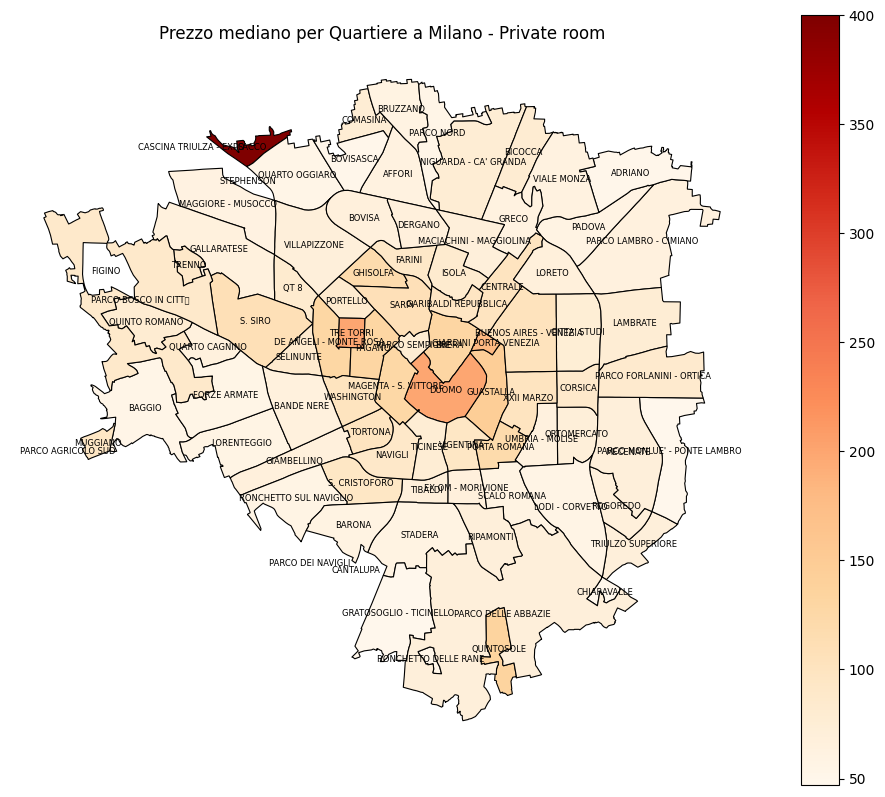

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2456322403.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


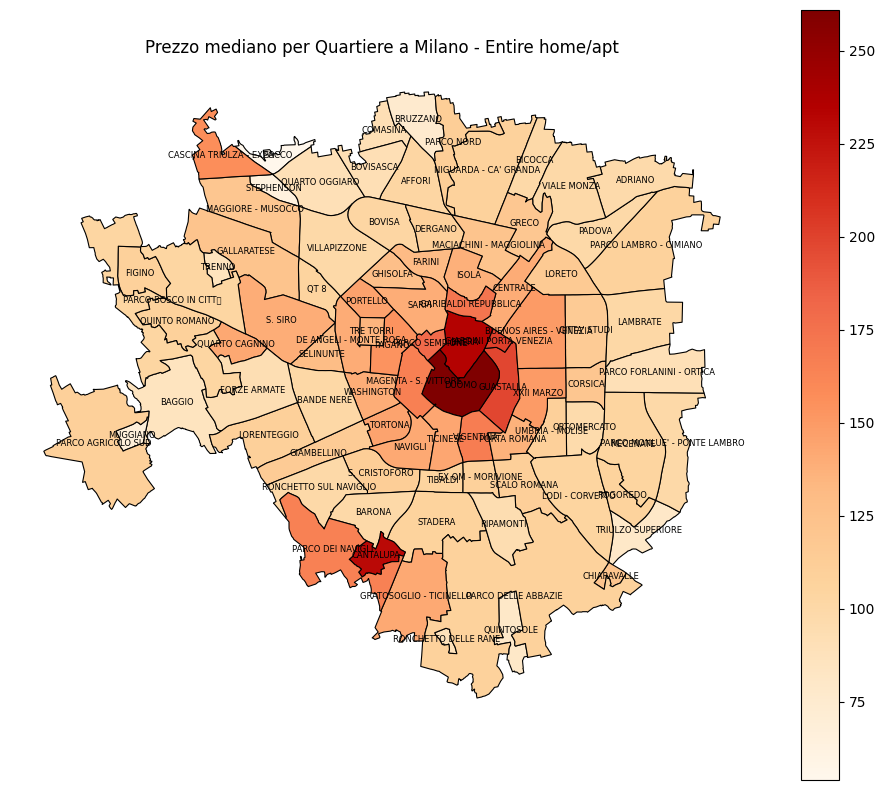

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2456322403.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


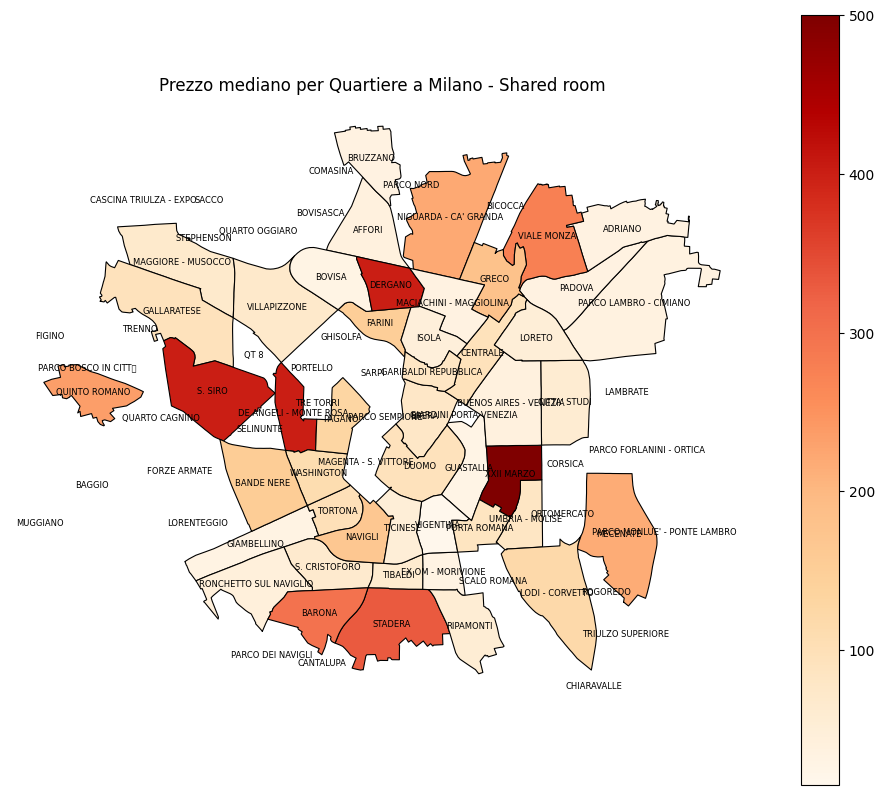

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2456322403.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid


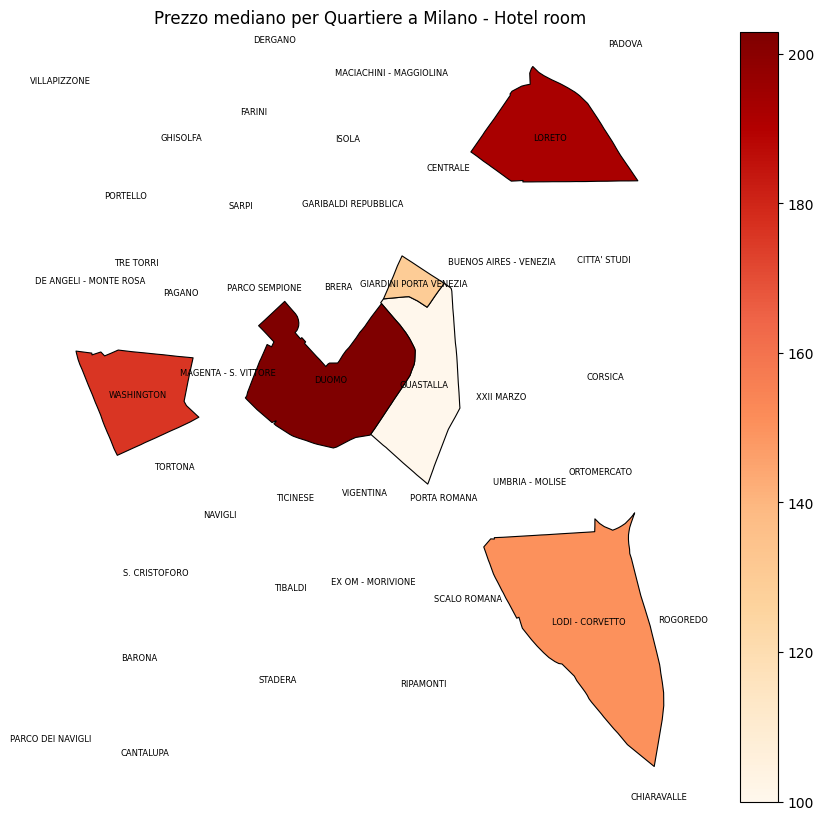

In [23]:


for rt in room_types:
    # Filtra i dati per questo room_type
    subset = df_price[df_price["room_type"] == rt]
    # Calcola il prezzo medio per quartiere
    avg_price = subset.groupby("quartiere")["price"].median().reset_index()
    avg_price.columns = ["quartiere", "avg_price"]
    
    # Merge con il GeoDataFrame
    gdf_merged = gdf.merge(avg_price, on="quartiere", how="left")
    
    # Calcola il centroid di ogni quartiere
    # (Attenzione: alcuni centroidi potrebbero cadere fuori dal poligono, specie se ha forma irregolare)
    gdf_merged["centroid"] = gdf_merged.geometry.centroid
    
    # Crea la figura
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Disegna la mappa colorata in base a "avg_price"
    gdf_merged.plot(
        column="avg_price",
        cmap="OrRd",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )
    
    # Aggiungi il nome del quartiere sopra il disegno
    for idx, row in gdf_merged.iterrows():
        # Verifica che la geometria e il nome quartiere siano validi
        if not row["geometry"].is_empty and pd.notnull(row["quartiere"]):
            ax.annotate(
                text=row["quartiere"],
                xy=(row["centroid"].x, row["centroid"].y),
                ha="center",            # center horizontally
                va="center",            # center vertically
                fontsize=6,             # regola la dimensione del font
                color="black"
            )
    
    ax.set_title(f"Prezzo mediano per Quartiere a Milano - {rt}")
    ax.axis("off")
    plt.show()


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:56: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")


Saved: /Users/stellaandorno/Desktop/airbnb_milan/figures/median_price_per_person_Private_room.png


/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


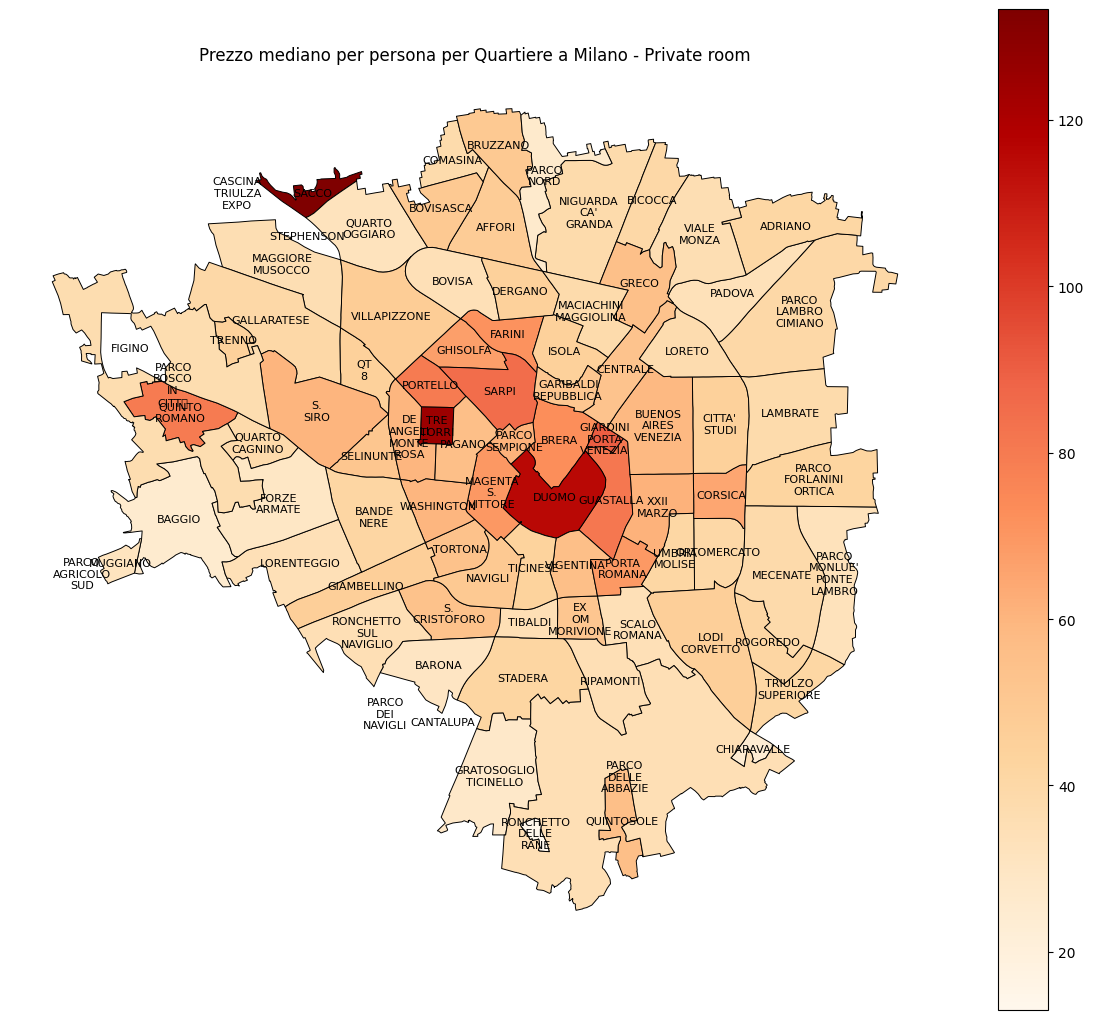

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:56: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")


Saved: /Users/stellaandorno/Desktop/airbnb_milan/figures/median_price_per_person_Entire_home_apt.png


/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


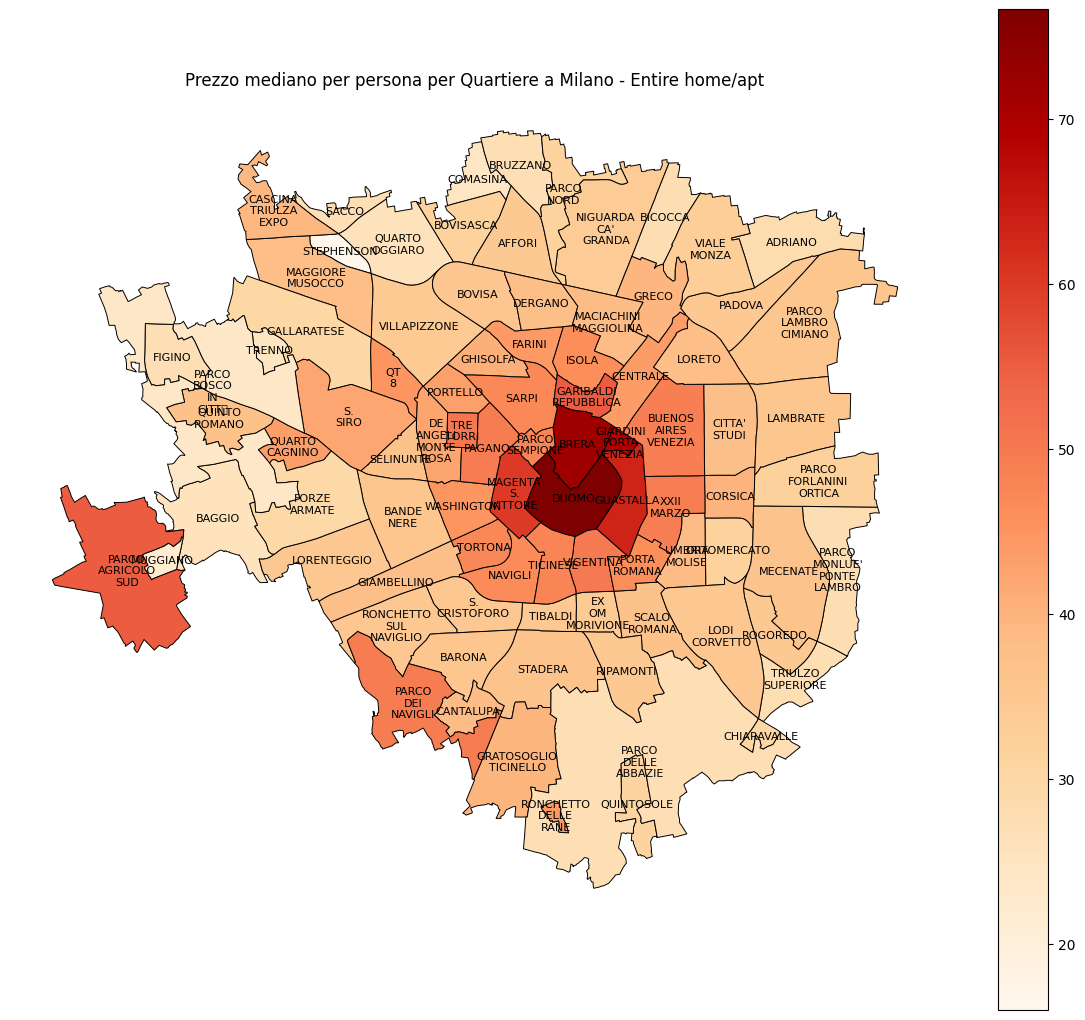

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid
/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:56: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")


Saved: /Users/stellaandorno/Desktop/airbnb_milan/figures/median_price_per_person_Shared_room.png


/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


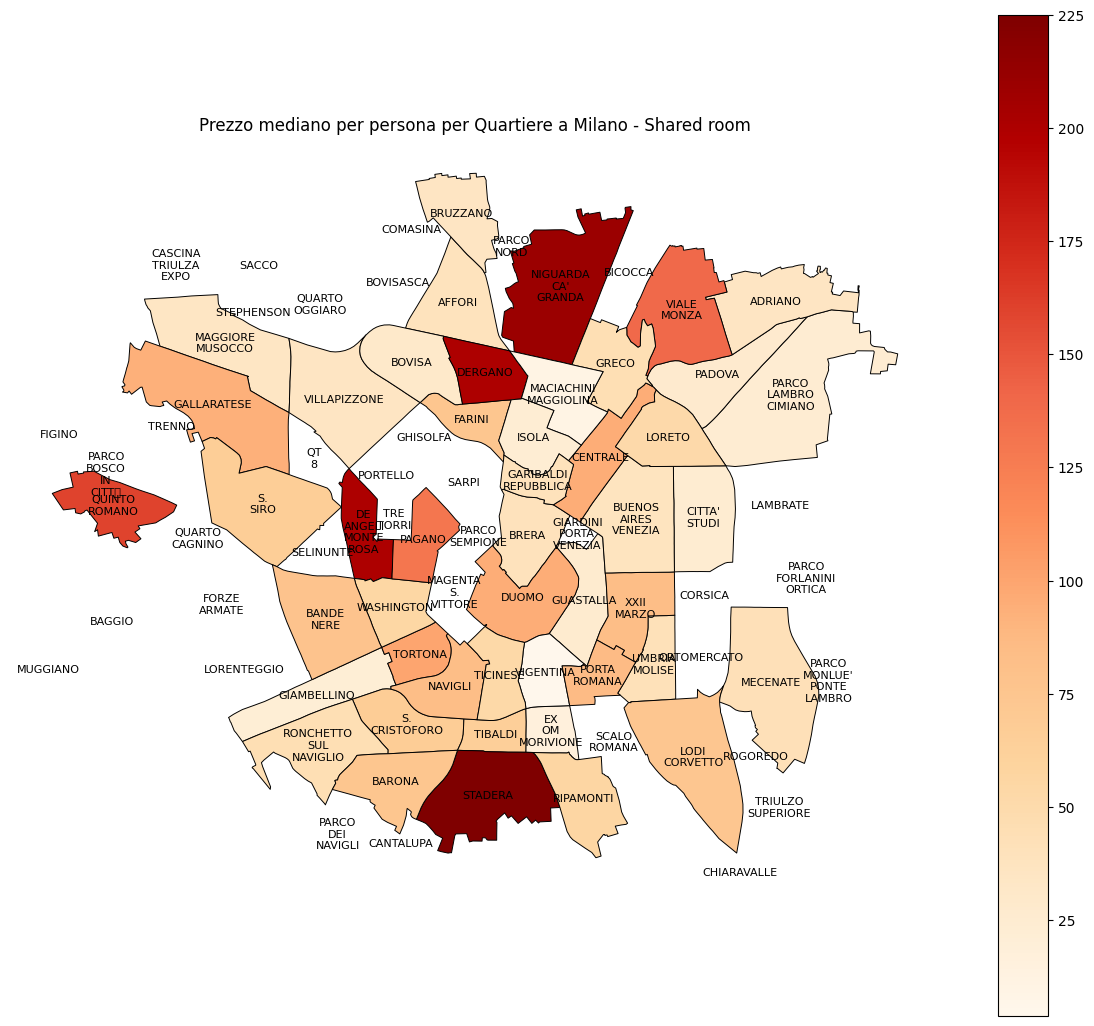

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_10080/2517283495.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_merged["centroid"] = gdf_merged.geometry.centroid


Saved: /Users/stellaandorno/Desktop/airbnb_milan/figures/median_price_per_person_Hotel_room.png


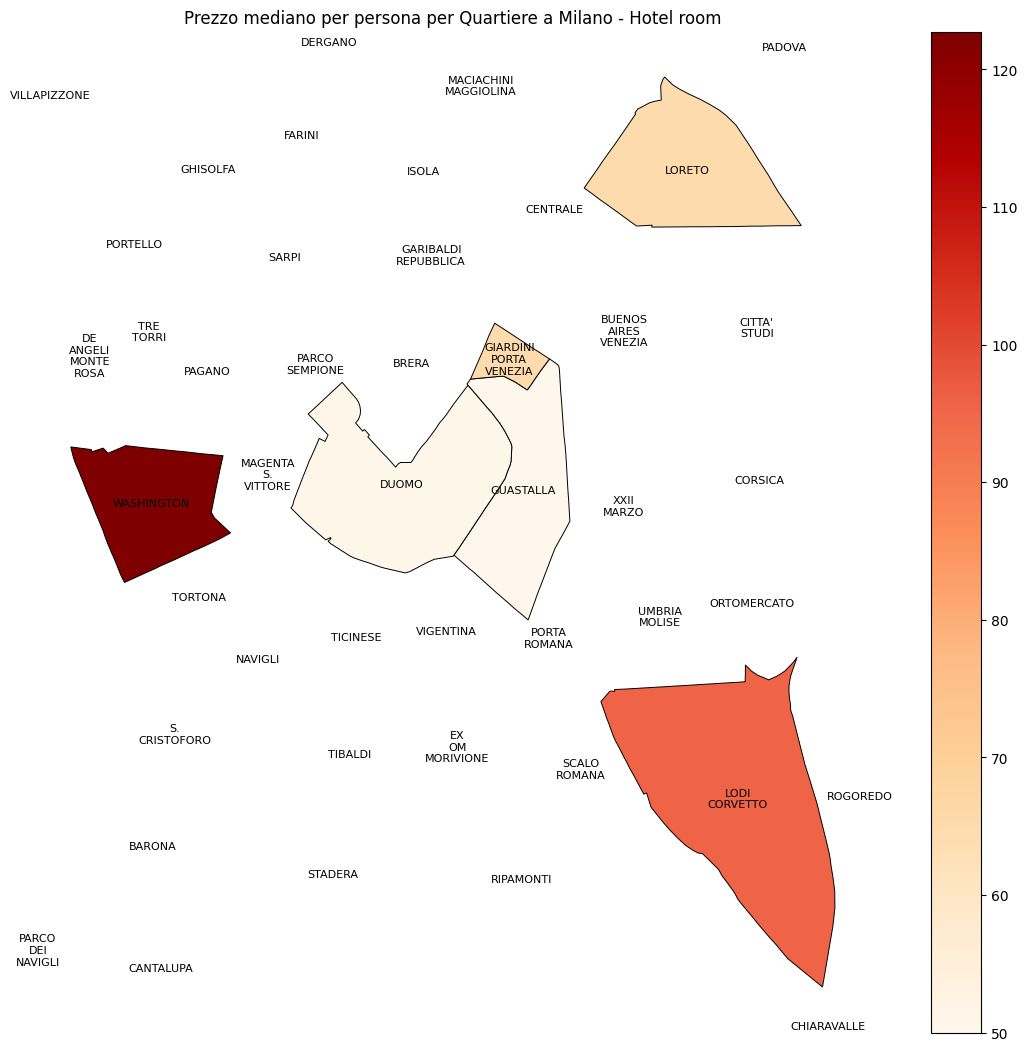

In [ ]:

cwd = Path.cwd().resolve()
project_root = cwd.parent if cwd.name == "notebooks" else cwd

# figures/ at repo root
figures_dir = project_root / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

df_price = df_price[df_price["accommodates"] > 0].copy()
df_price["price_per_person"] = df_price["price"] / df_price["accommodates"]

def safe_slug(s: str) -> str:
    # replace slashes and other odd chars -> underscore
    s = s.replace("/", "_")
    s = re.sub(r"[^A-Za-z0-9_.-]+", "_", s)
    return s.strip("_")

for rt in room_types:
    subset = df_price[df_price["room_type"] == rt]

    avg_price = subset.groupby("quartiere")["price_per_person"].median().reset_index()
    avg_price.columns = ["quartiere", "avg_price_per_person"]

    gdf_merged = gdf.merge(avg_price, on="quartiere", how="left")
    gdf_merged["centroid"] = gdf_merged.geometry.centroid

    fig, ax = plt.subplots(1, 1, figsize=(15, 13))
    gdf_merged.plot(
        column="avg_price_per_person",
        cmap="OrRd",
        linewidth=0.7,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    for _, row in gdf_merged.iterrows():
        if not row["geometry"].is_empty and pd.notnull(row["quartiere"]):
            ax.annotate(
                text=row["quartiere"].replace(" - ", "\n").replace(" ", "\n"),
                xy=(row["centroid"].x, row["centroid"].y),
                ha="center", va="center",
                fontweight="medium", fontsize=8, color="black"
            )

    ax.set_title(f"Prezzo mediano per persona per Quartiere a Milano - {rt}")
    ax.axis("off")

    # --- Safe filename ---
    rt_slug = safe_slug(rt)
    filename = figures_dir / f"median_price_per_person_{rt_slug}.png"

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")
    plt.show()

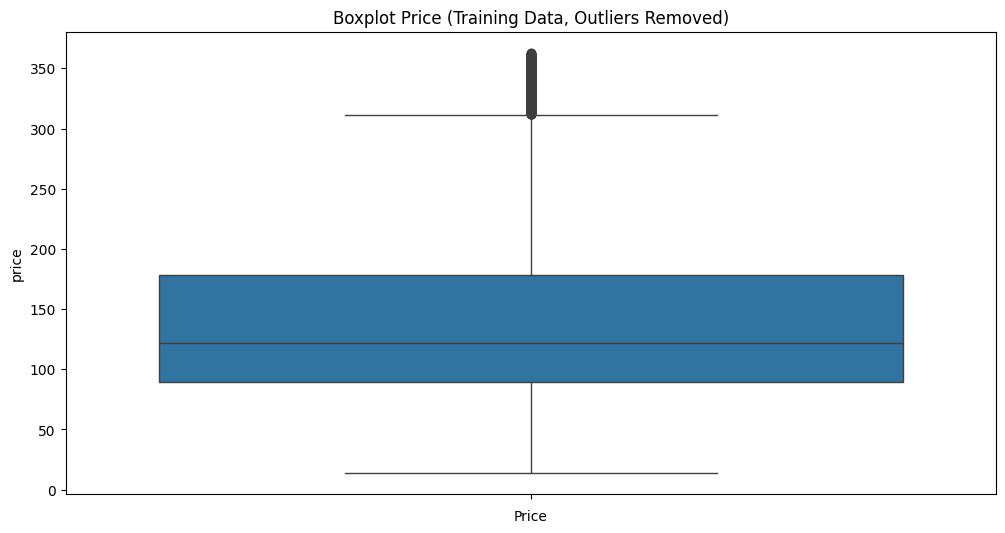

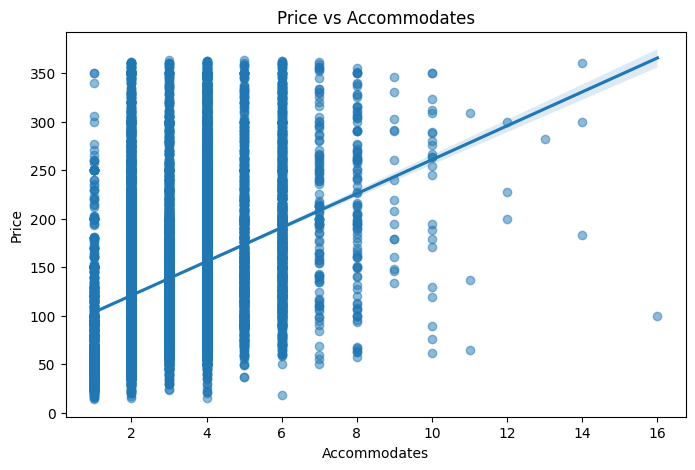

In [ ]:

# 1. Start with your existing data (you already have this working)
X = df.drop(columns=["price"])  # Features
y = df["price"]  # Target


# 3. Remove outliers from training data only
def remove_outliers(X_data, y_data, factor=1.5):
    q1 = y_data.quantile(0.25)
    q3 = y_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    
    # Get mask for non-outliers
    mask = (y_data >= lower_bound) & (y_data <= upper_bound)
    
    return X_data[mask], y_data[mask]


X, y = remove_outliers(X, y, factor=1.5)



plt.figure(figsize=(12, 6))
sns.boxplot(y)
plt.title("Boxplot Price (Training Data, Outliers Removed)")
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(x=X['accommodates'], y=y, scatter_kws={"alpha":0.5})
plt.title("Price vs Accommodates")
plt.xlabel("Accommodates")
plt.ylabel("Price")
plt.show()


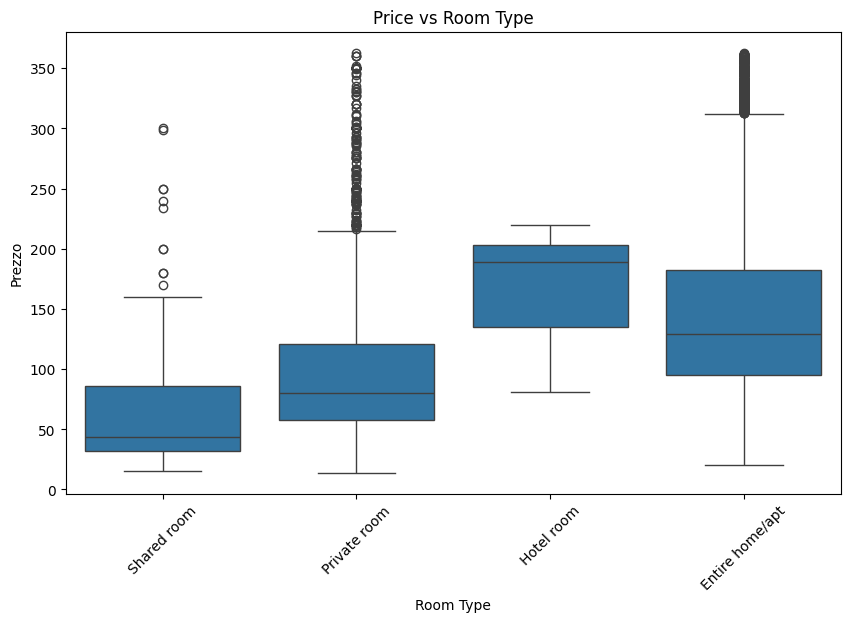

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=X['room_type'], y=y)
plt.title("Price vs Room Type")
plt.xlabel("Room Type")
plt.ylabel("Prezzo")
plt.xticks(rotation=45)
plt.show()


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/1297185876.py:15: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


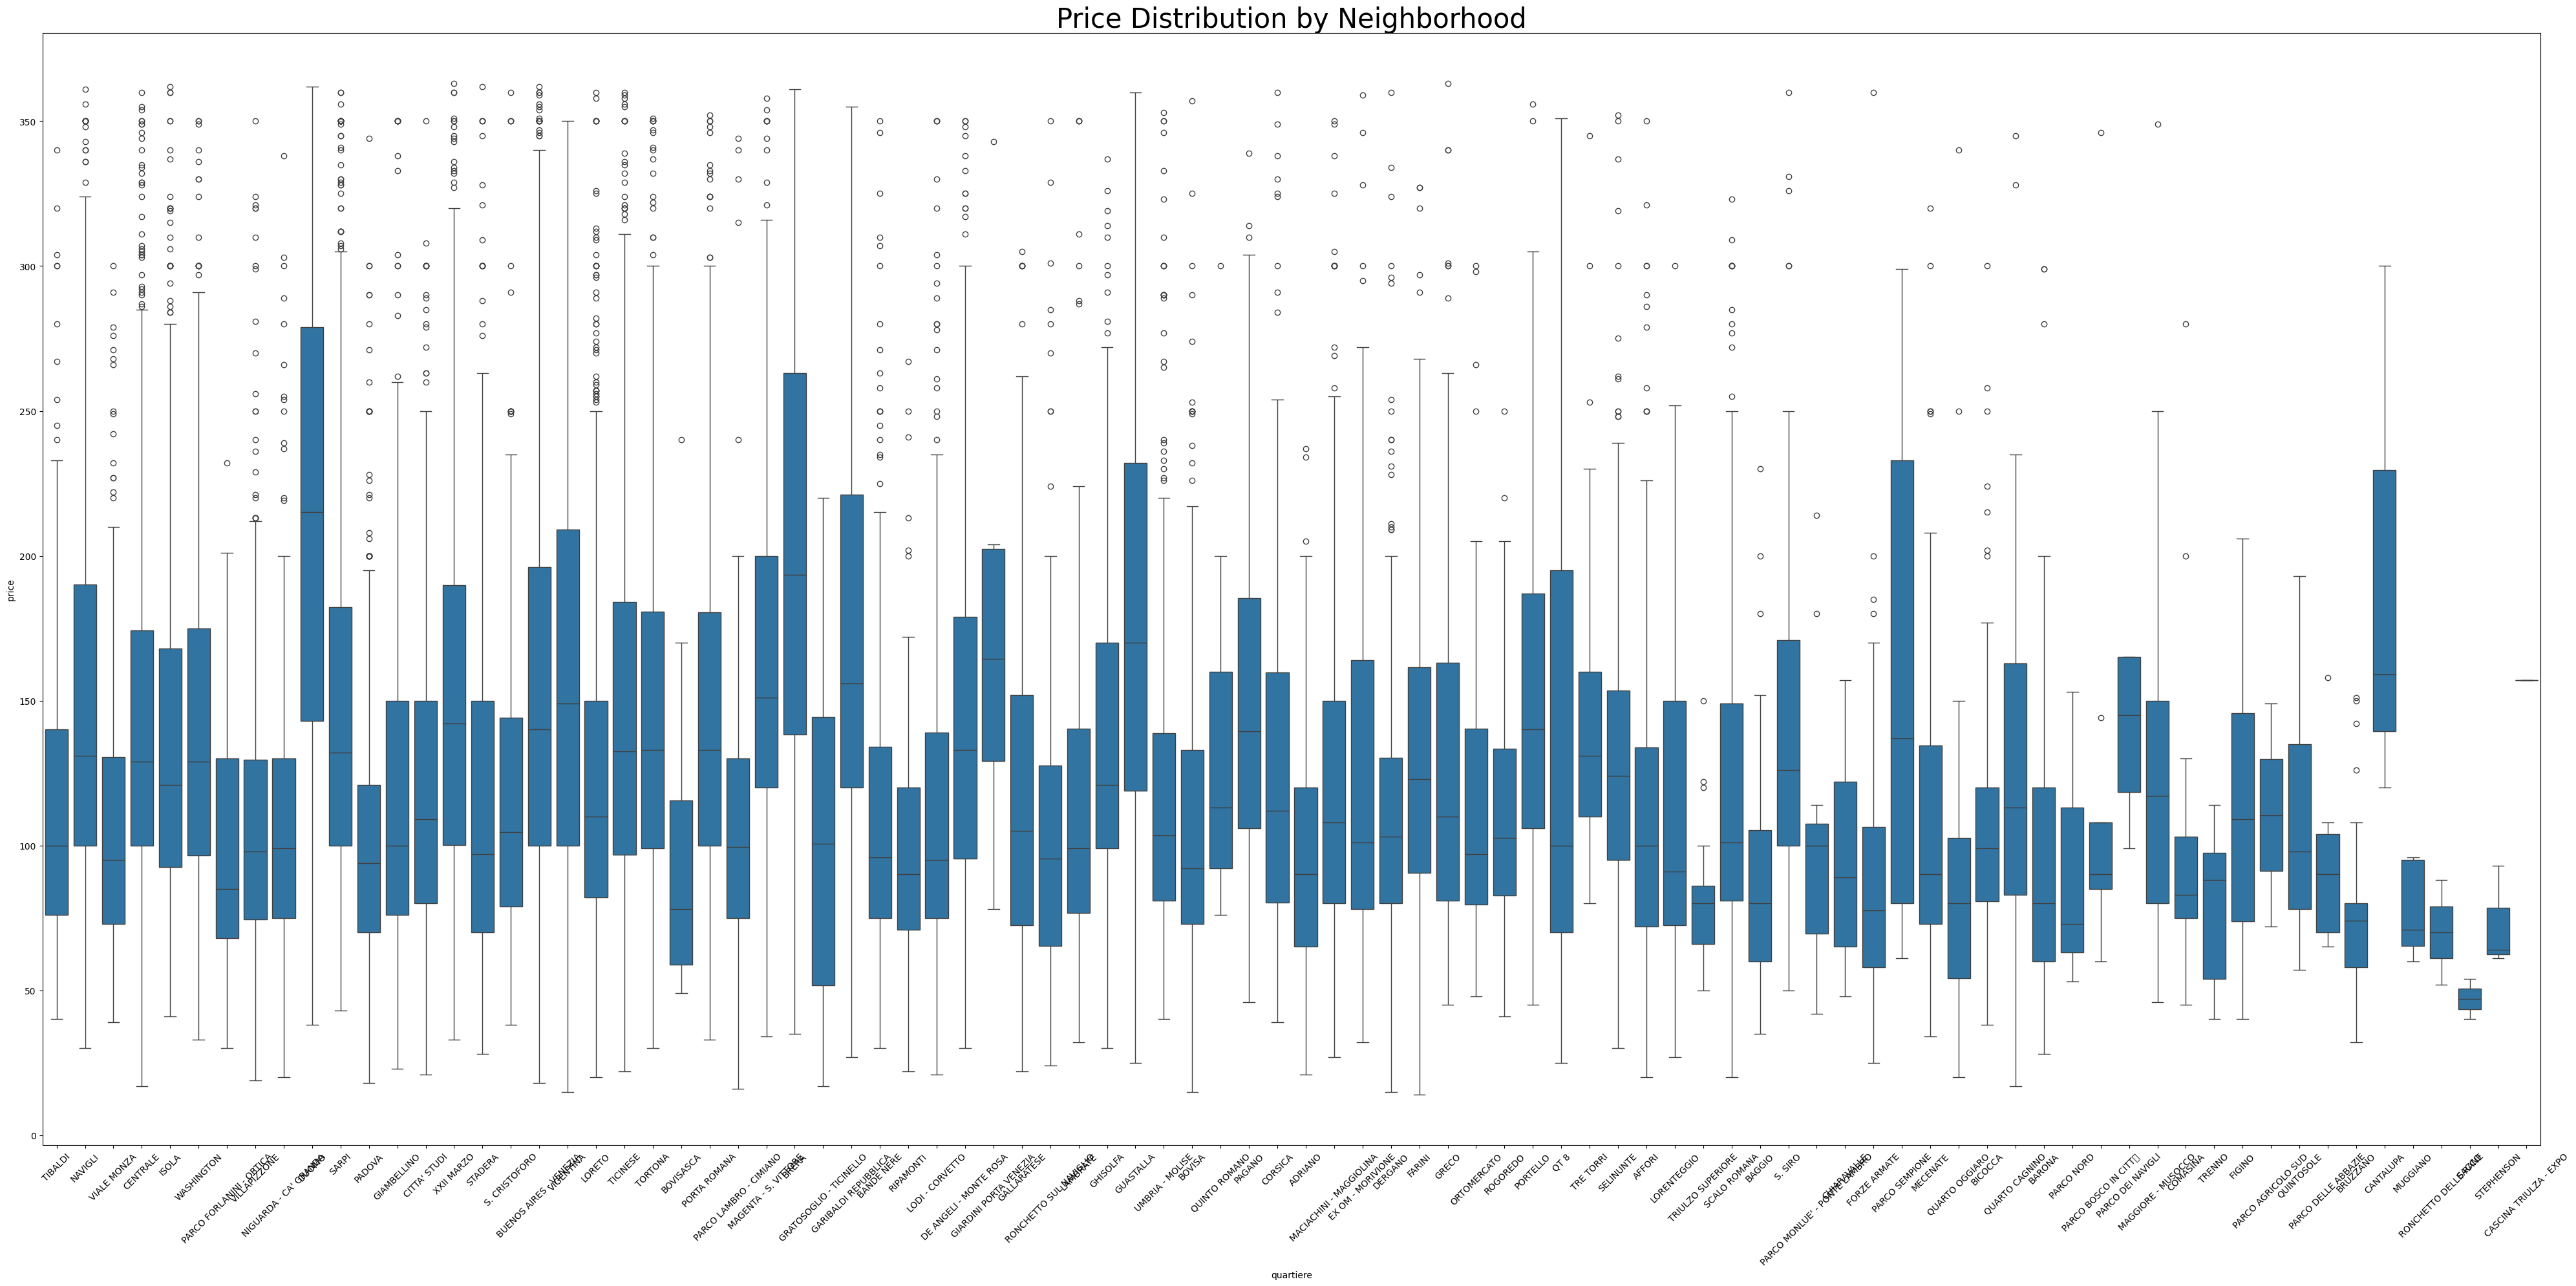

In [ ]:
# Recreate df_price using current X and y variables
df_price = pd.DataFrame({
    'quartiere': X['neighbourhood_cleansed'].str.upper(),
    'room_type': X['room_type'],
    'price': y
})

# Add municipality mapping
df_price['municipio'] = df_price['quartiere'].map(neighborhood_to_zone)

plt.figure(figsize=(40, 20))
sns.boxplot(data=df_price, x="quartiere", y="price")
plt.title("Price Distribution by Neighborhood", fontsize=40)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/2841478770.py:17: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


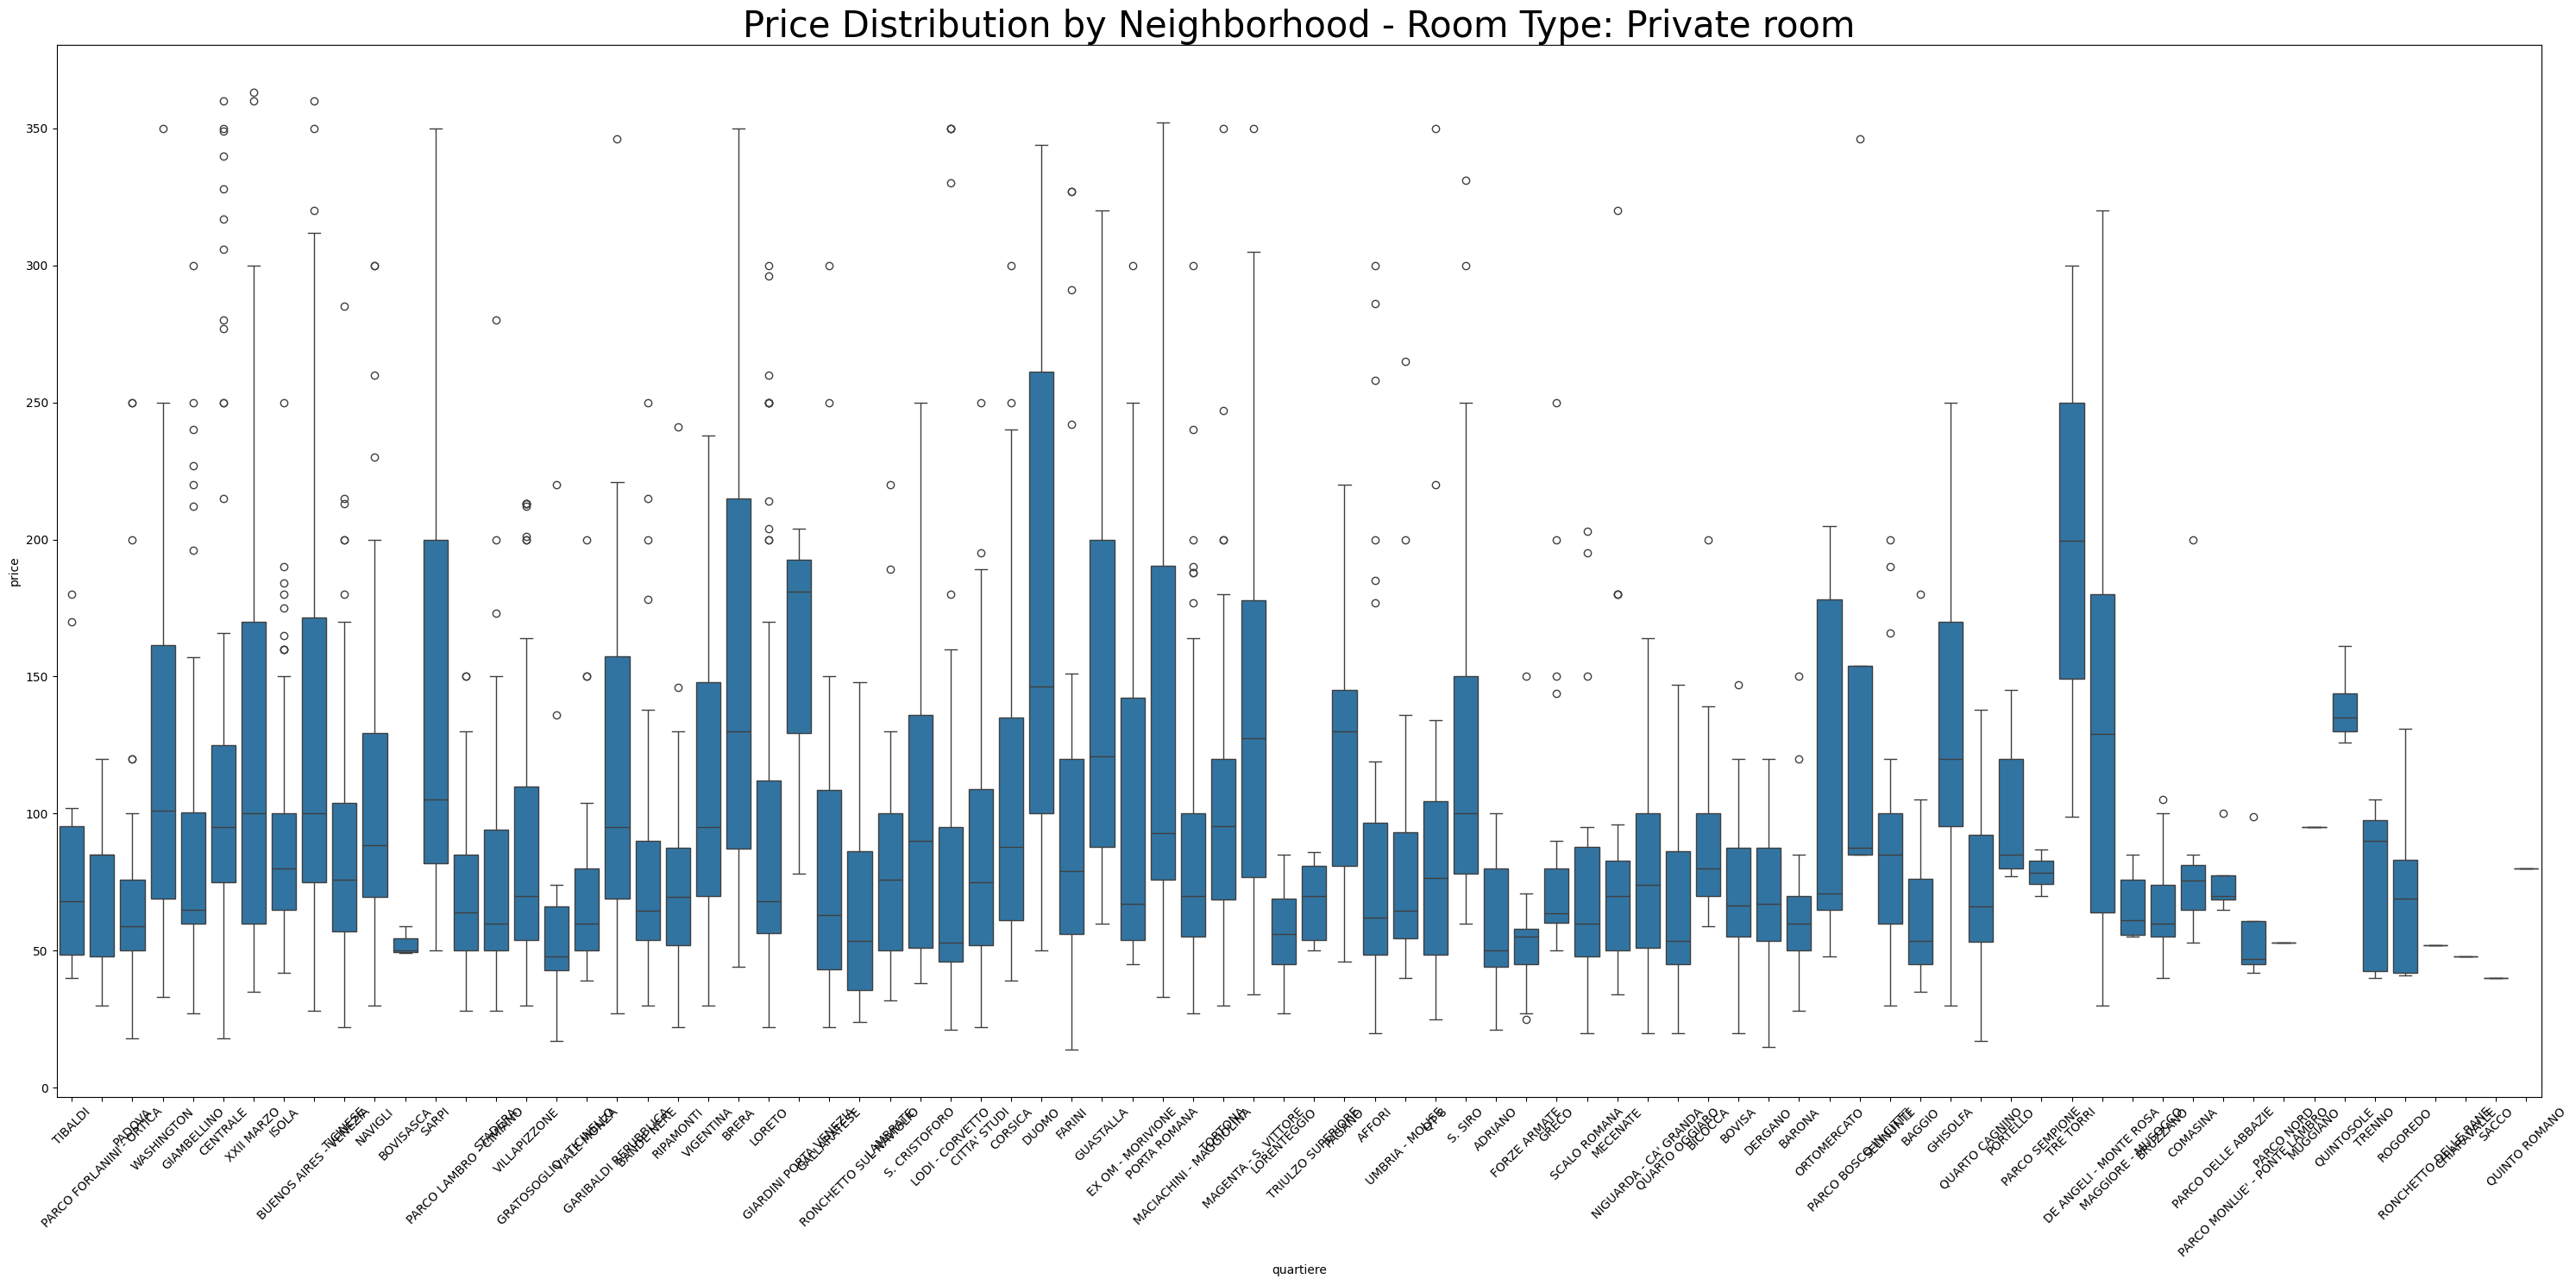

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/2841478770.py:17: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


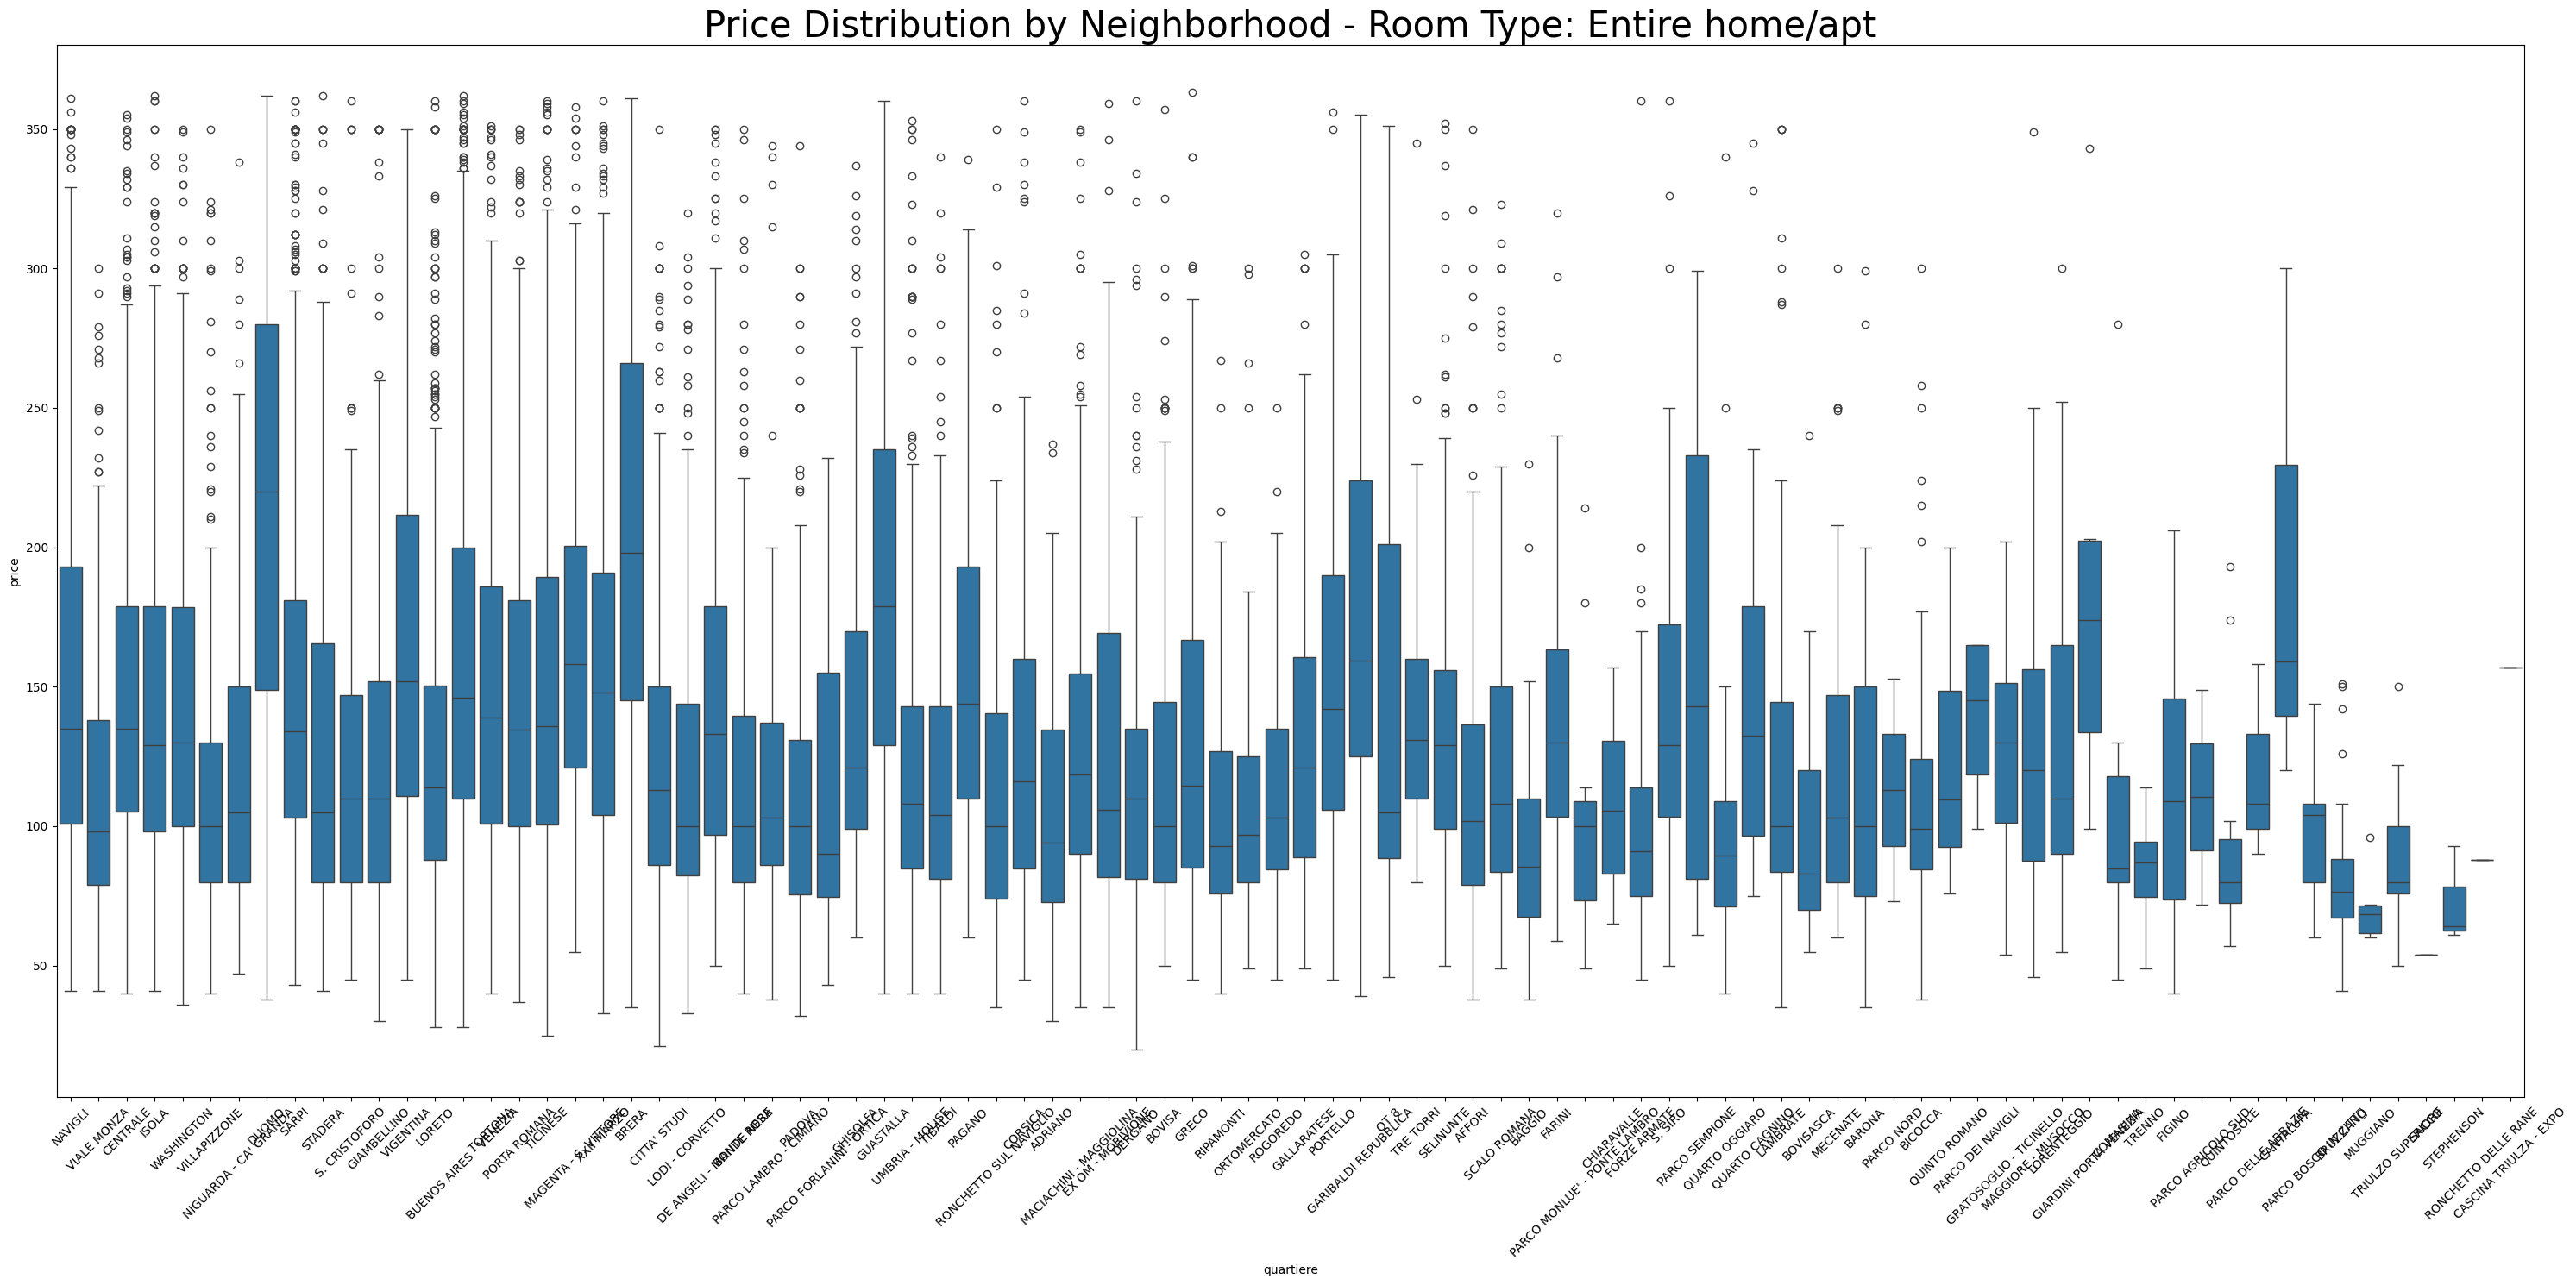

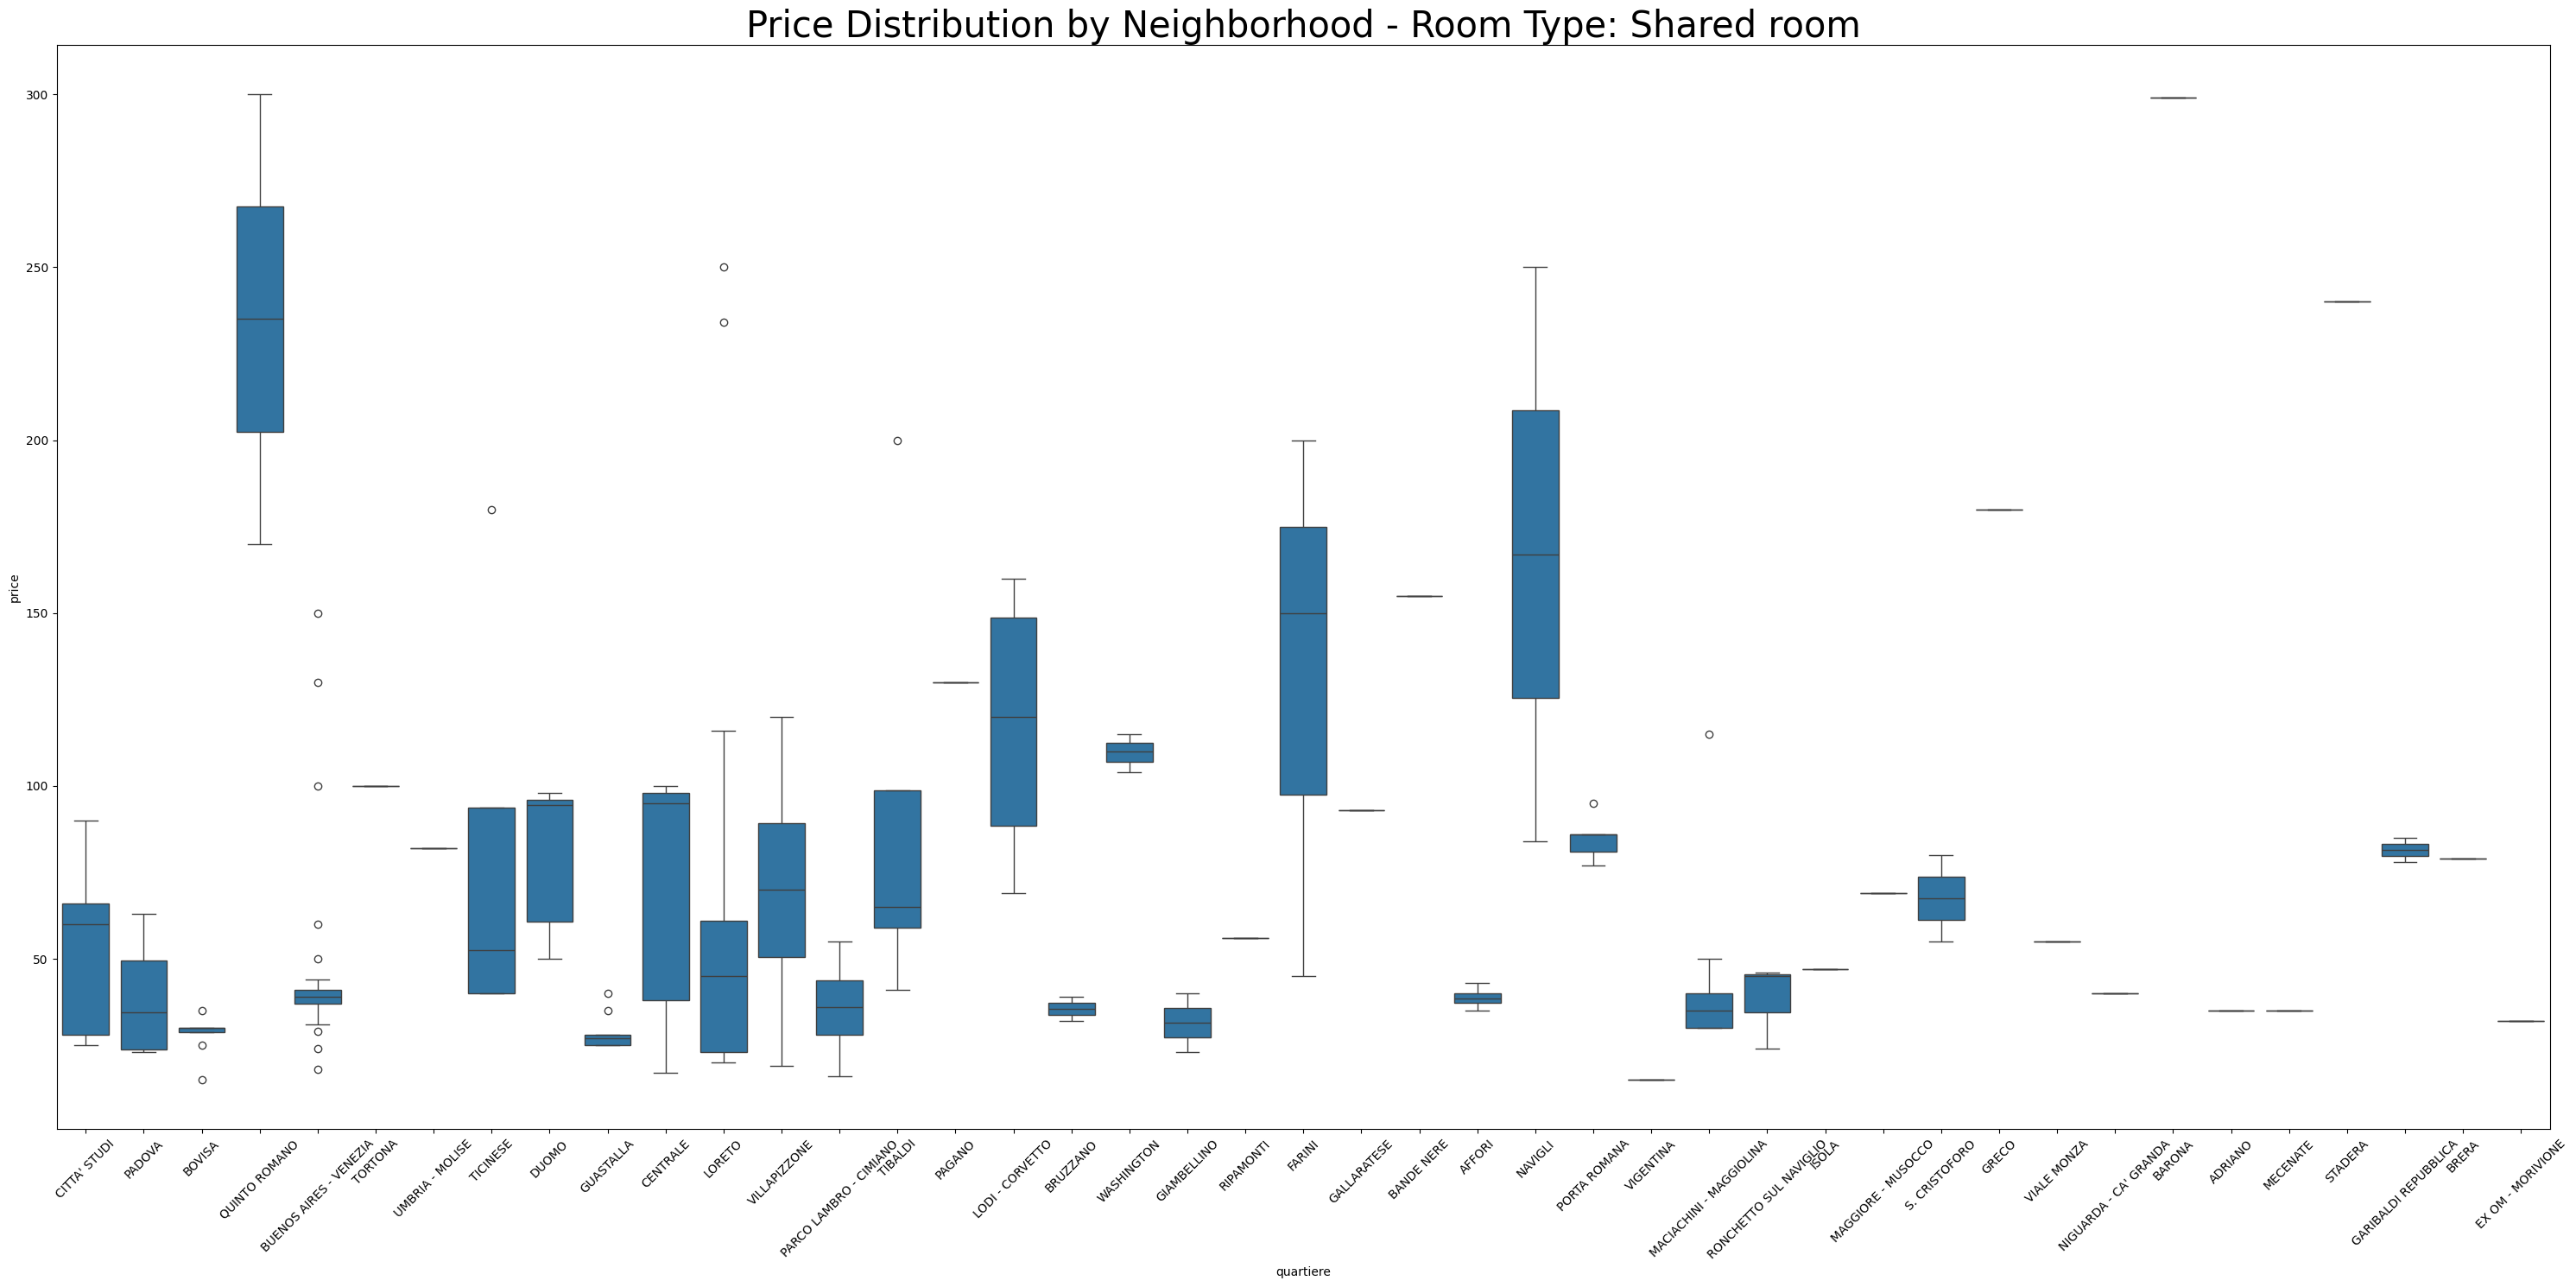

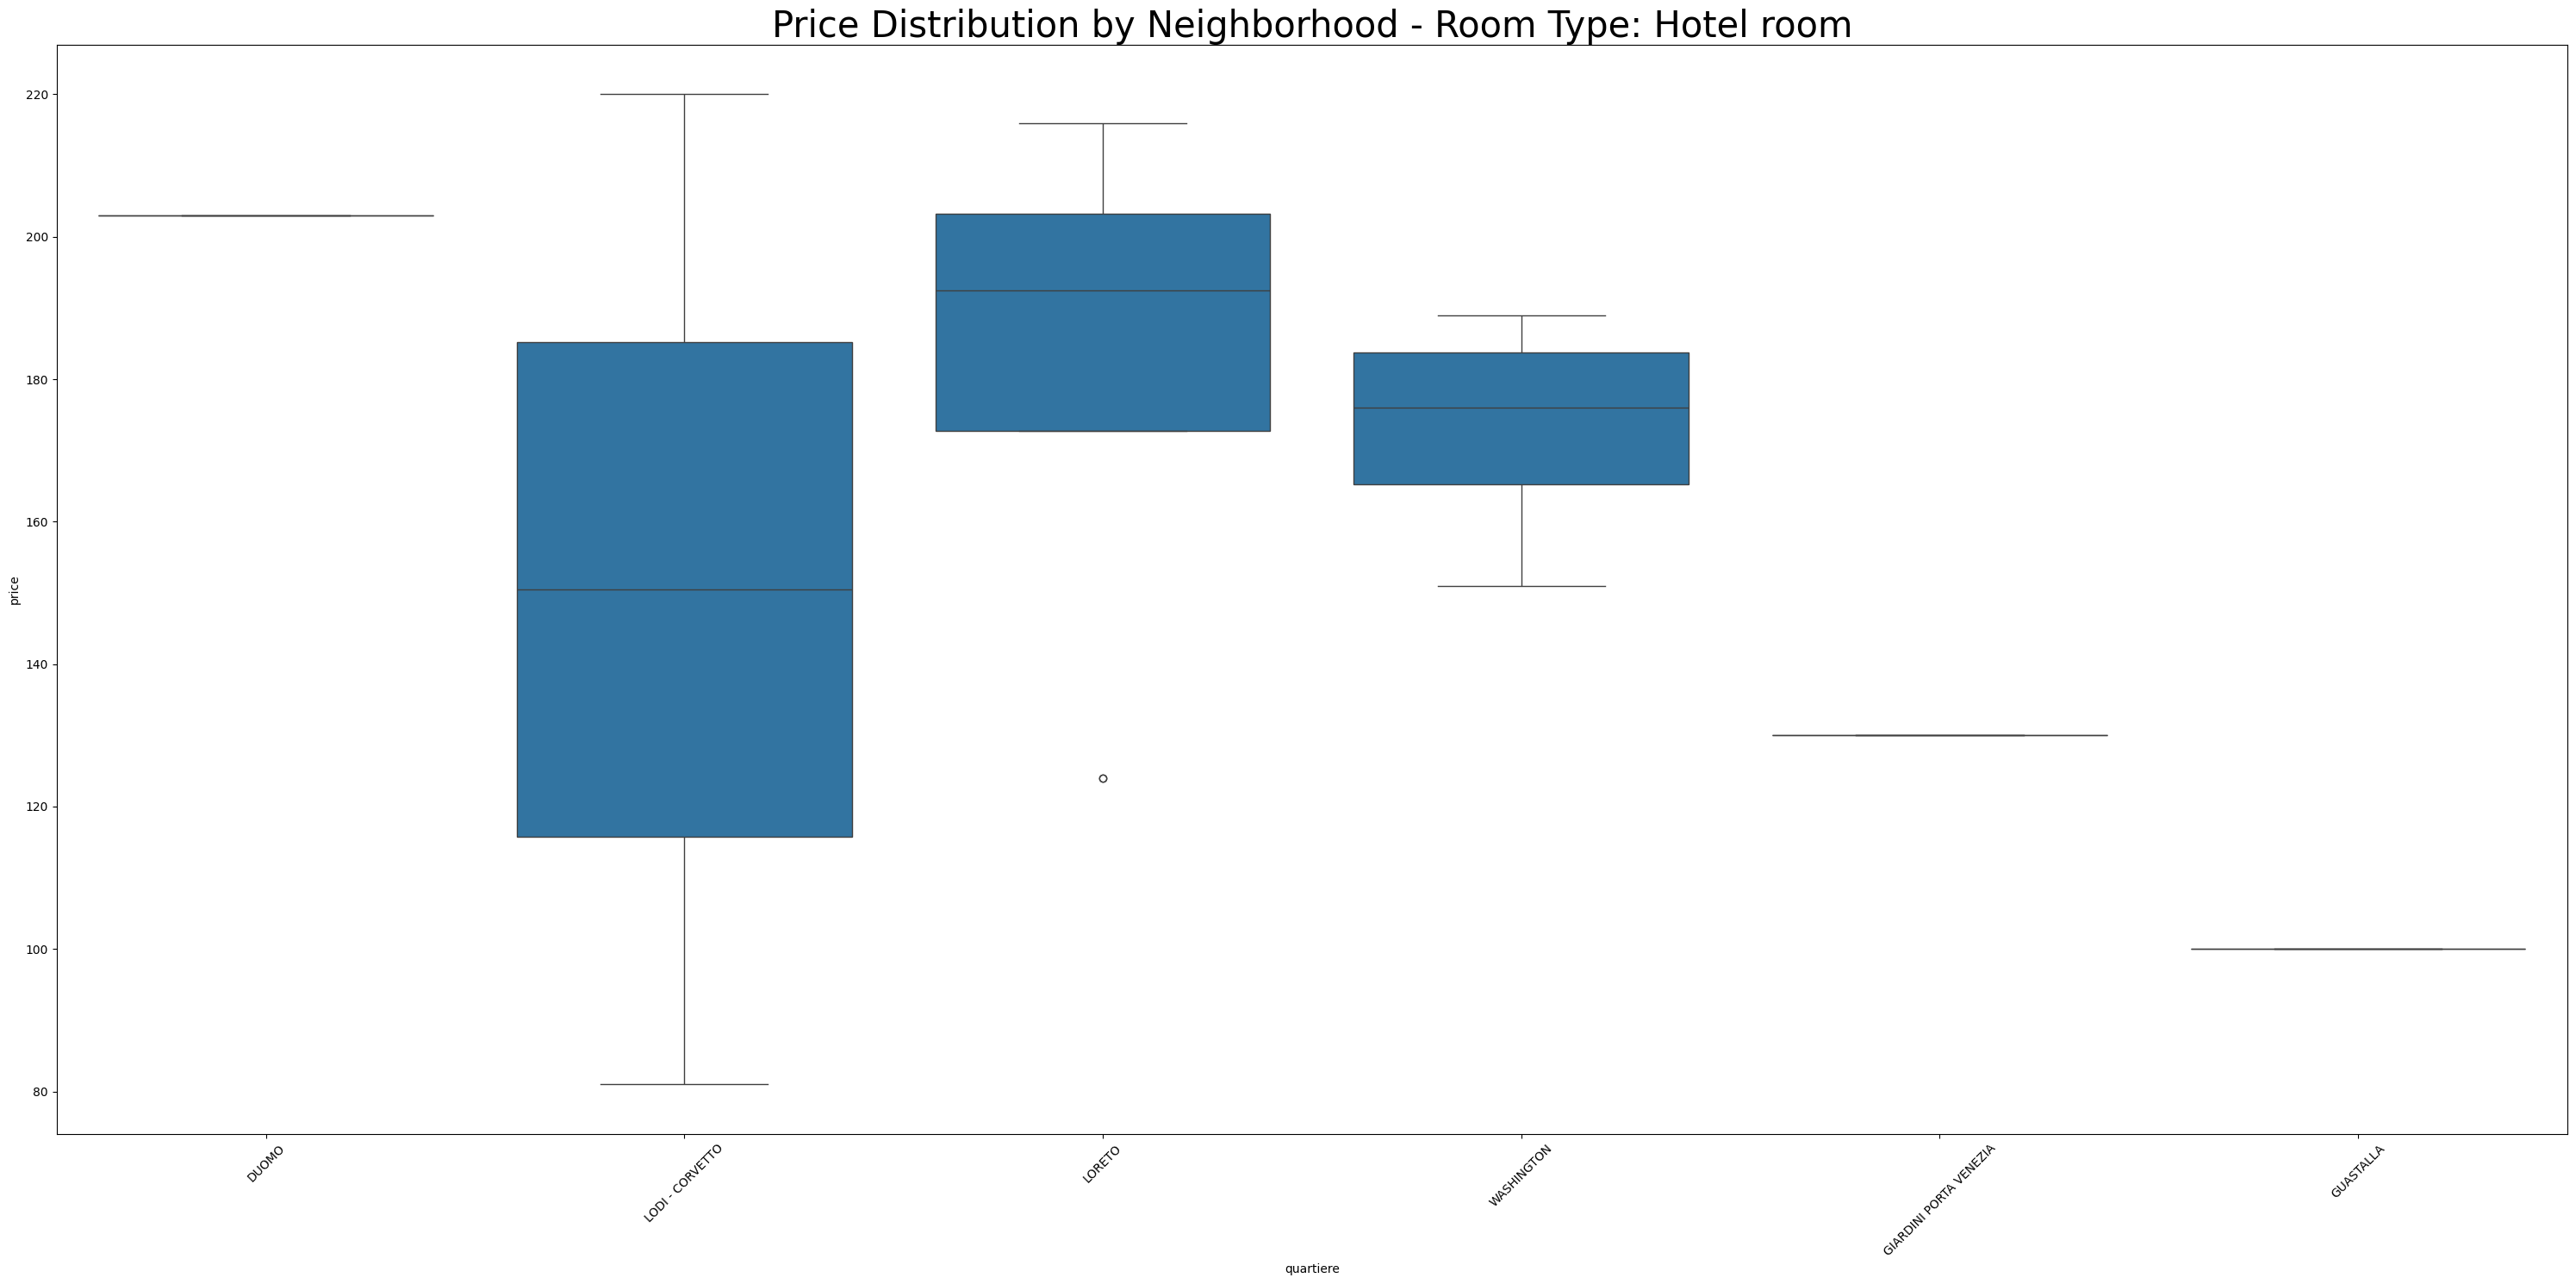

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ottieni i valori unici di room_type
room_types = df_price["room_type"].unique()

for rt in room_types:
    # Filtra il DataFrame per il room_type corrente
    subset = df_price[df_price["room_type"] == rt]
    
    # Crea una nuova figura per ogni room_type
    plt.figure(figsize=(30, 15))
    sns.boxplot(data=subset, x="quartiere", y="price")

    plt.title(f"Price Distribution by Neighborhood - Room Type: {rt}", fontsize = 40)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/3870618412.py:37: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


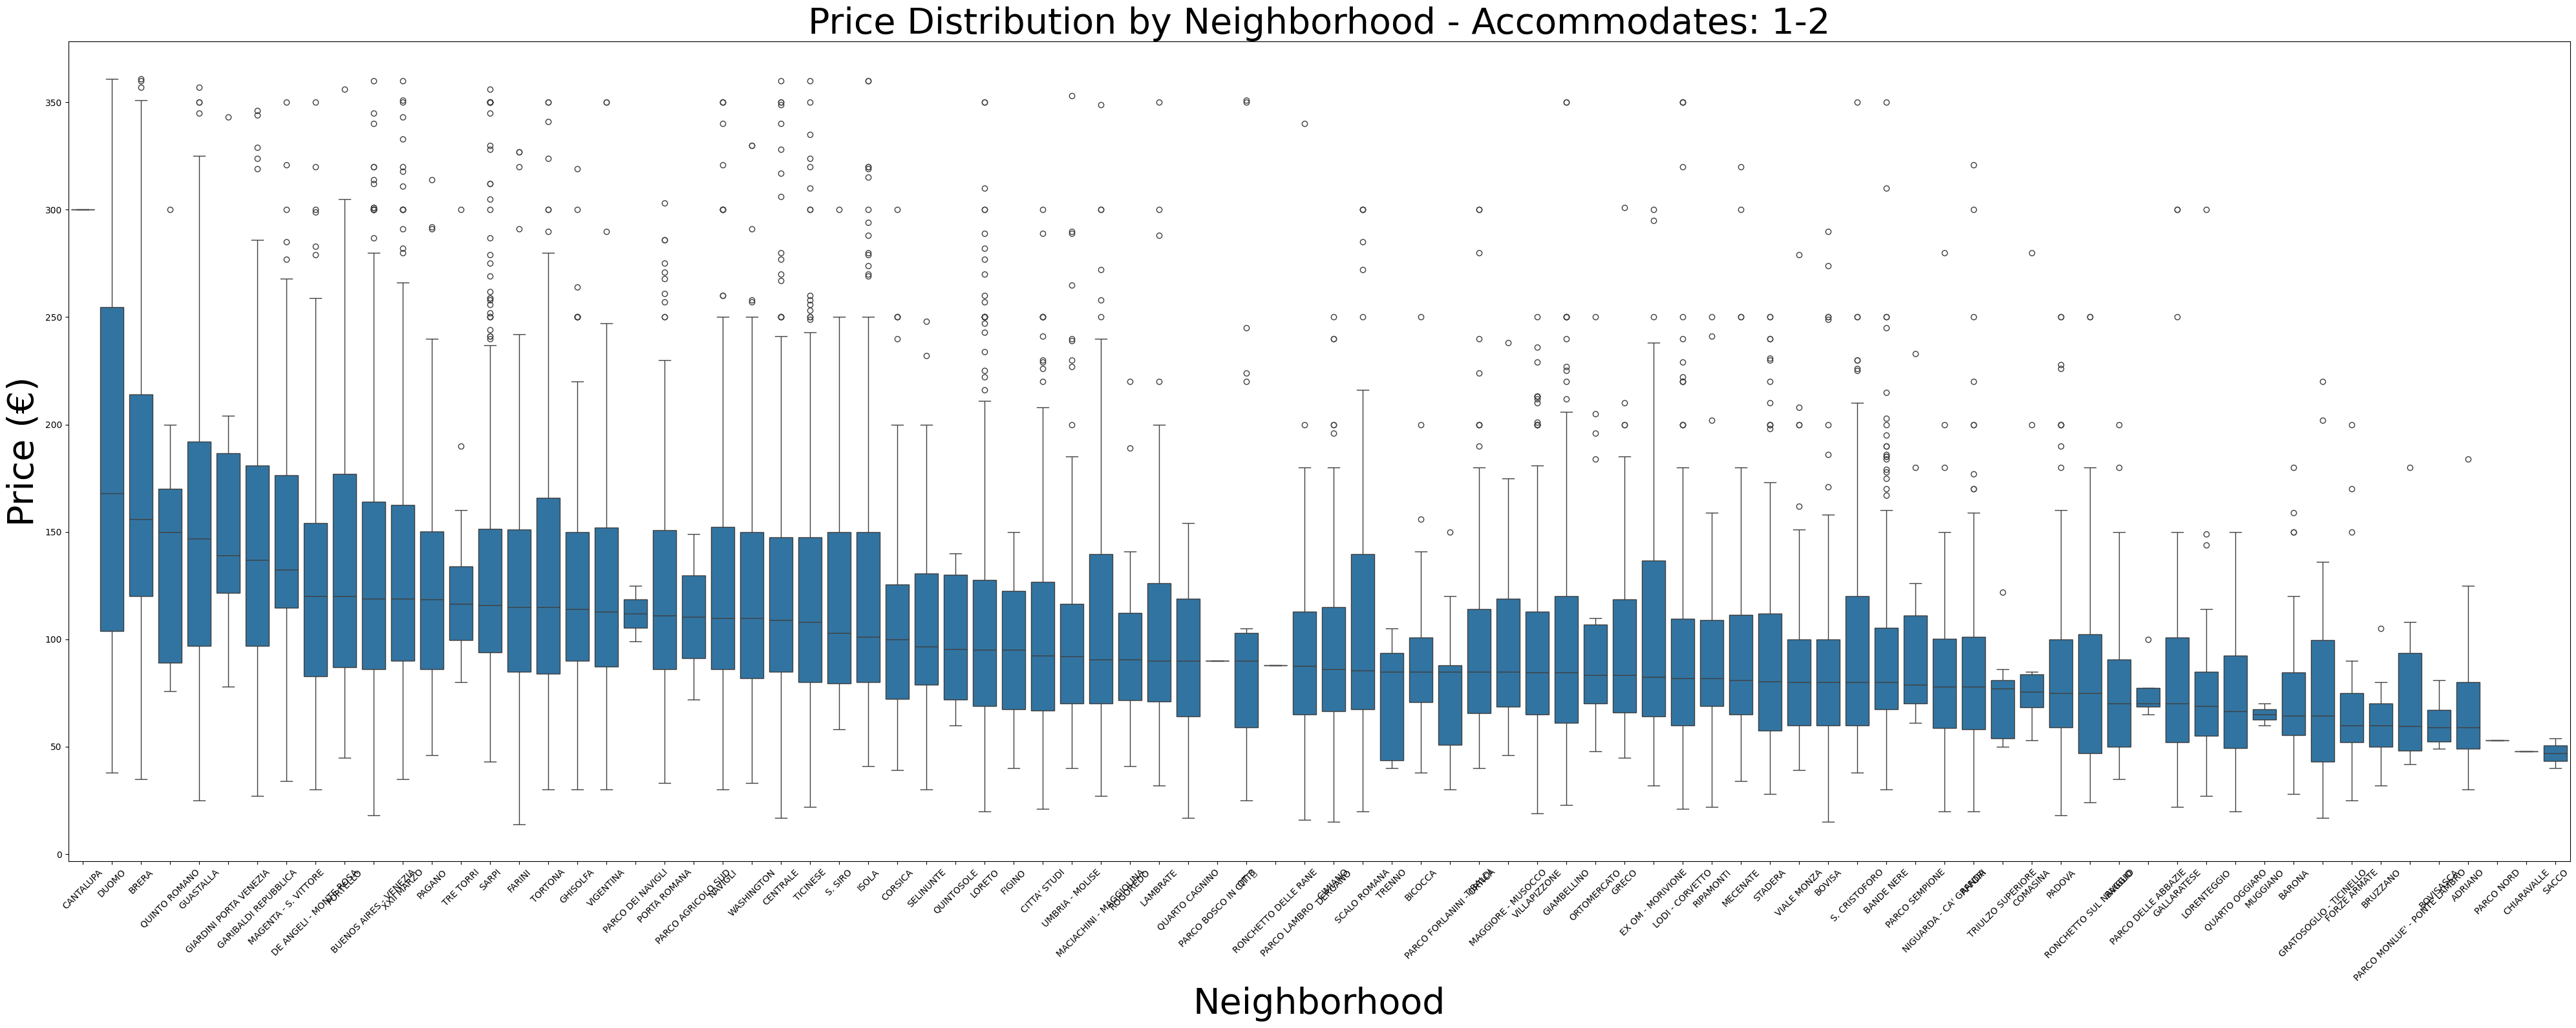

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/3870618412.py:37: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


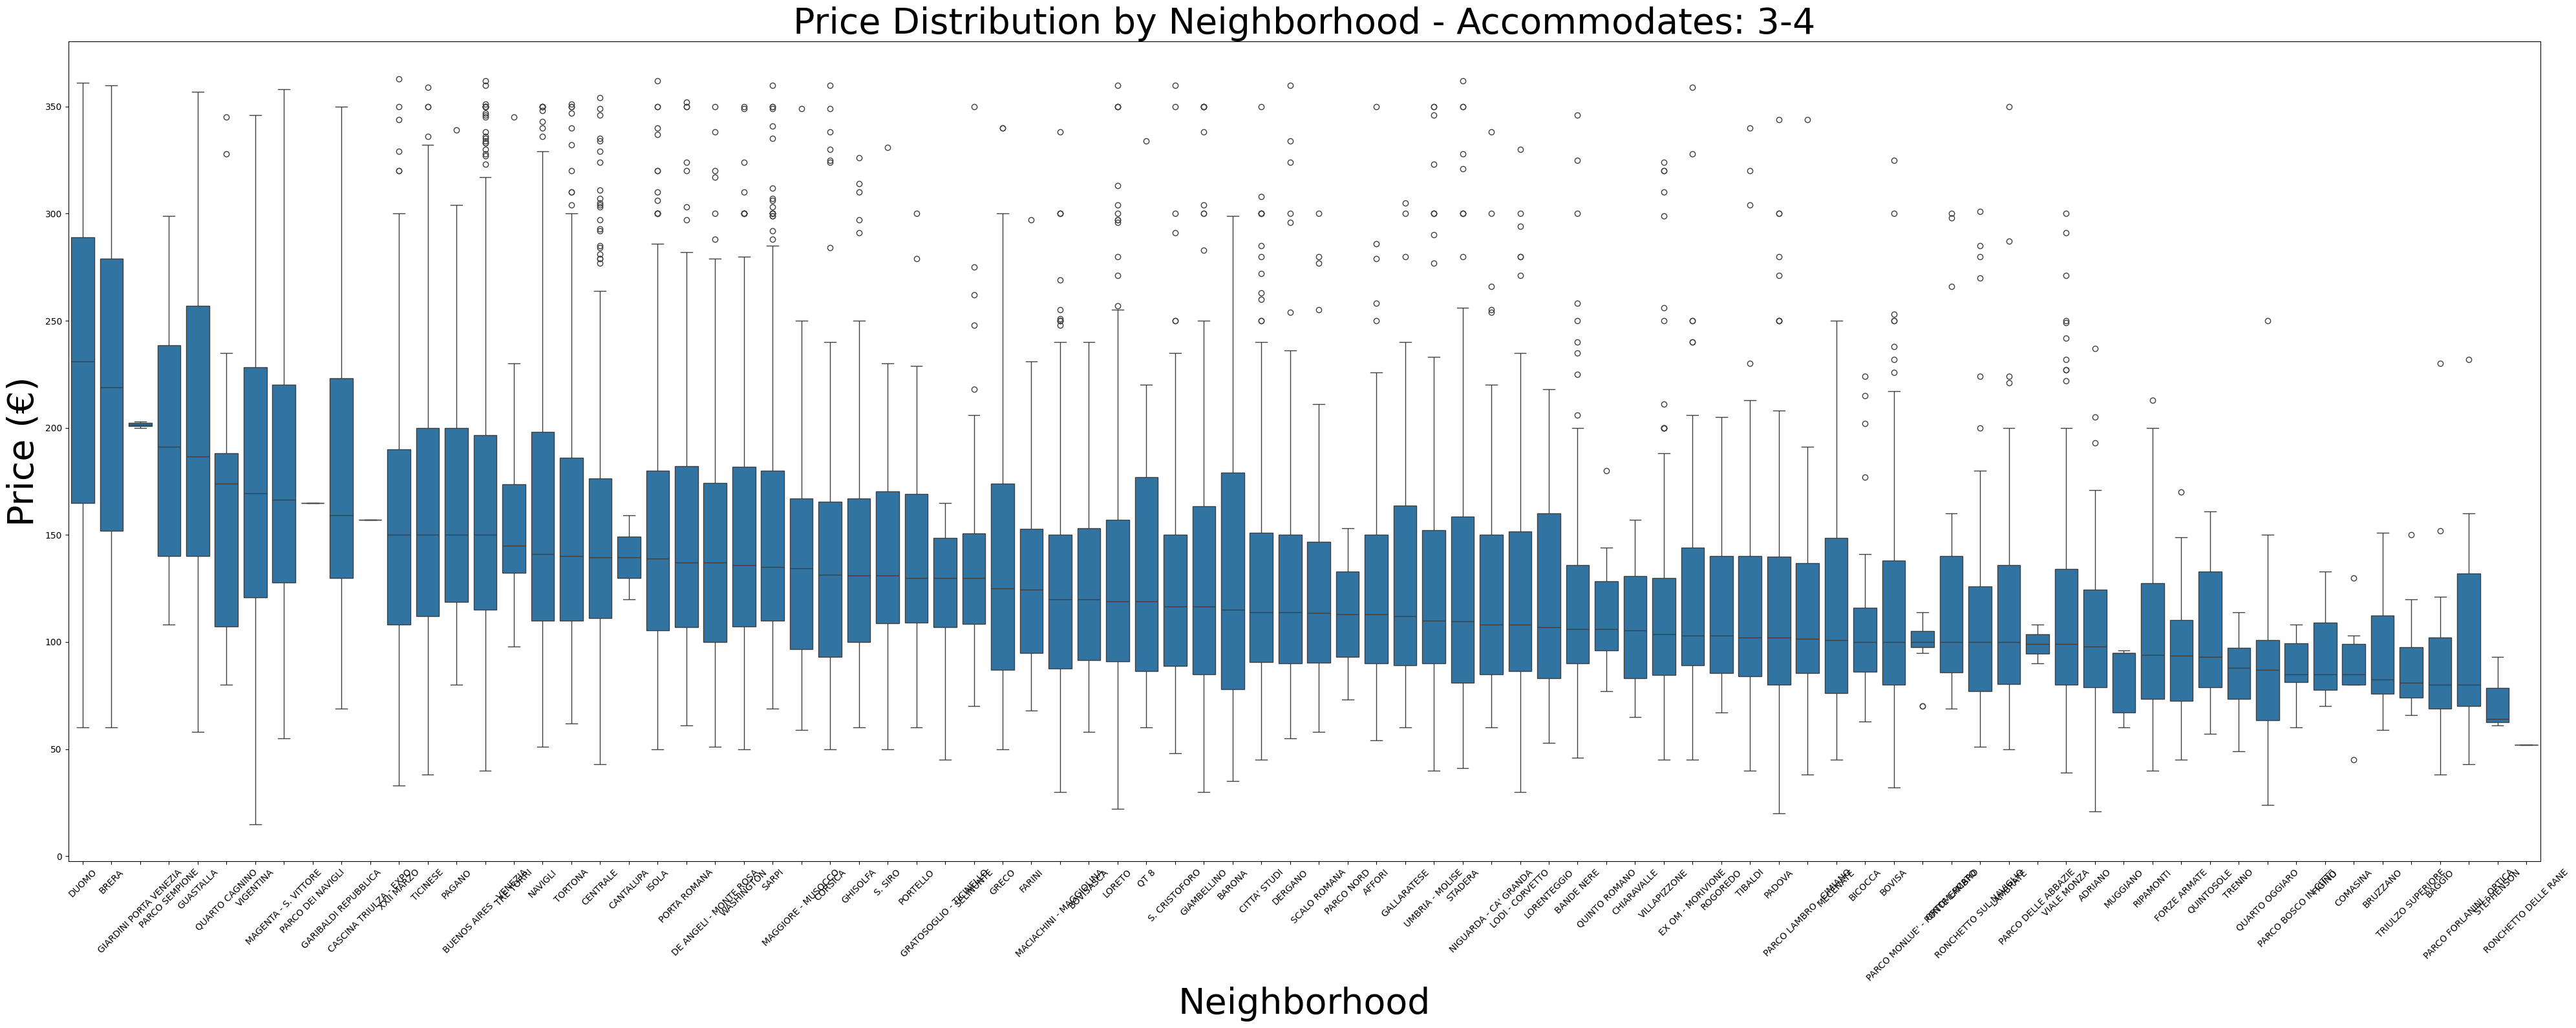

/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_9004/3870618412.py:37: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/stellaandorno/Desktop/airbnb_milan/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


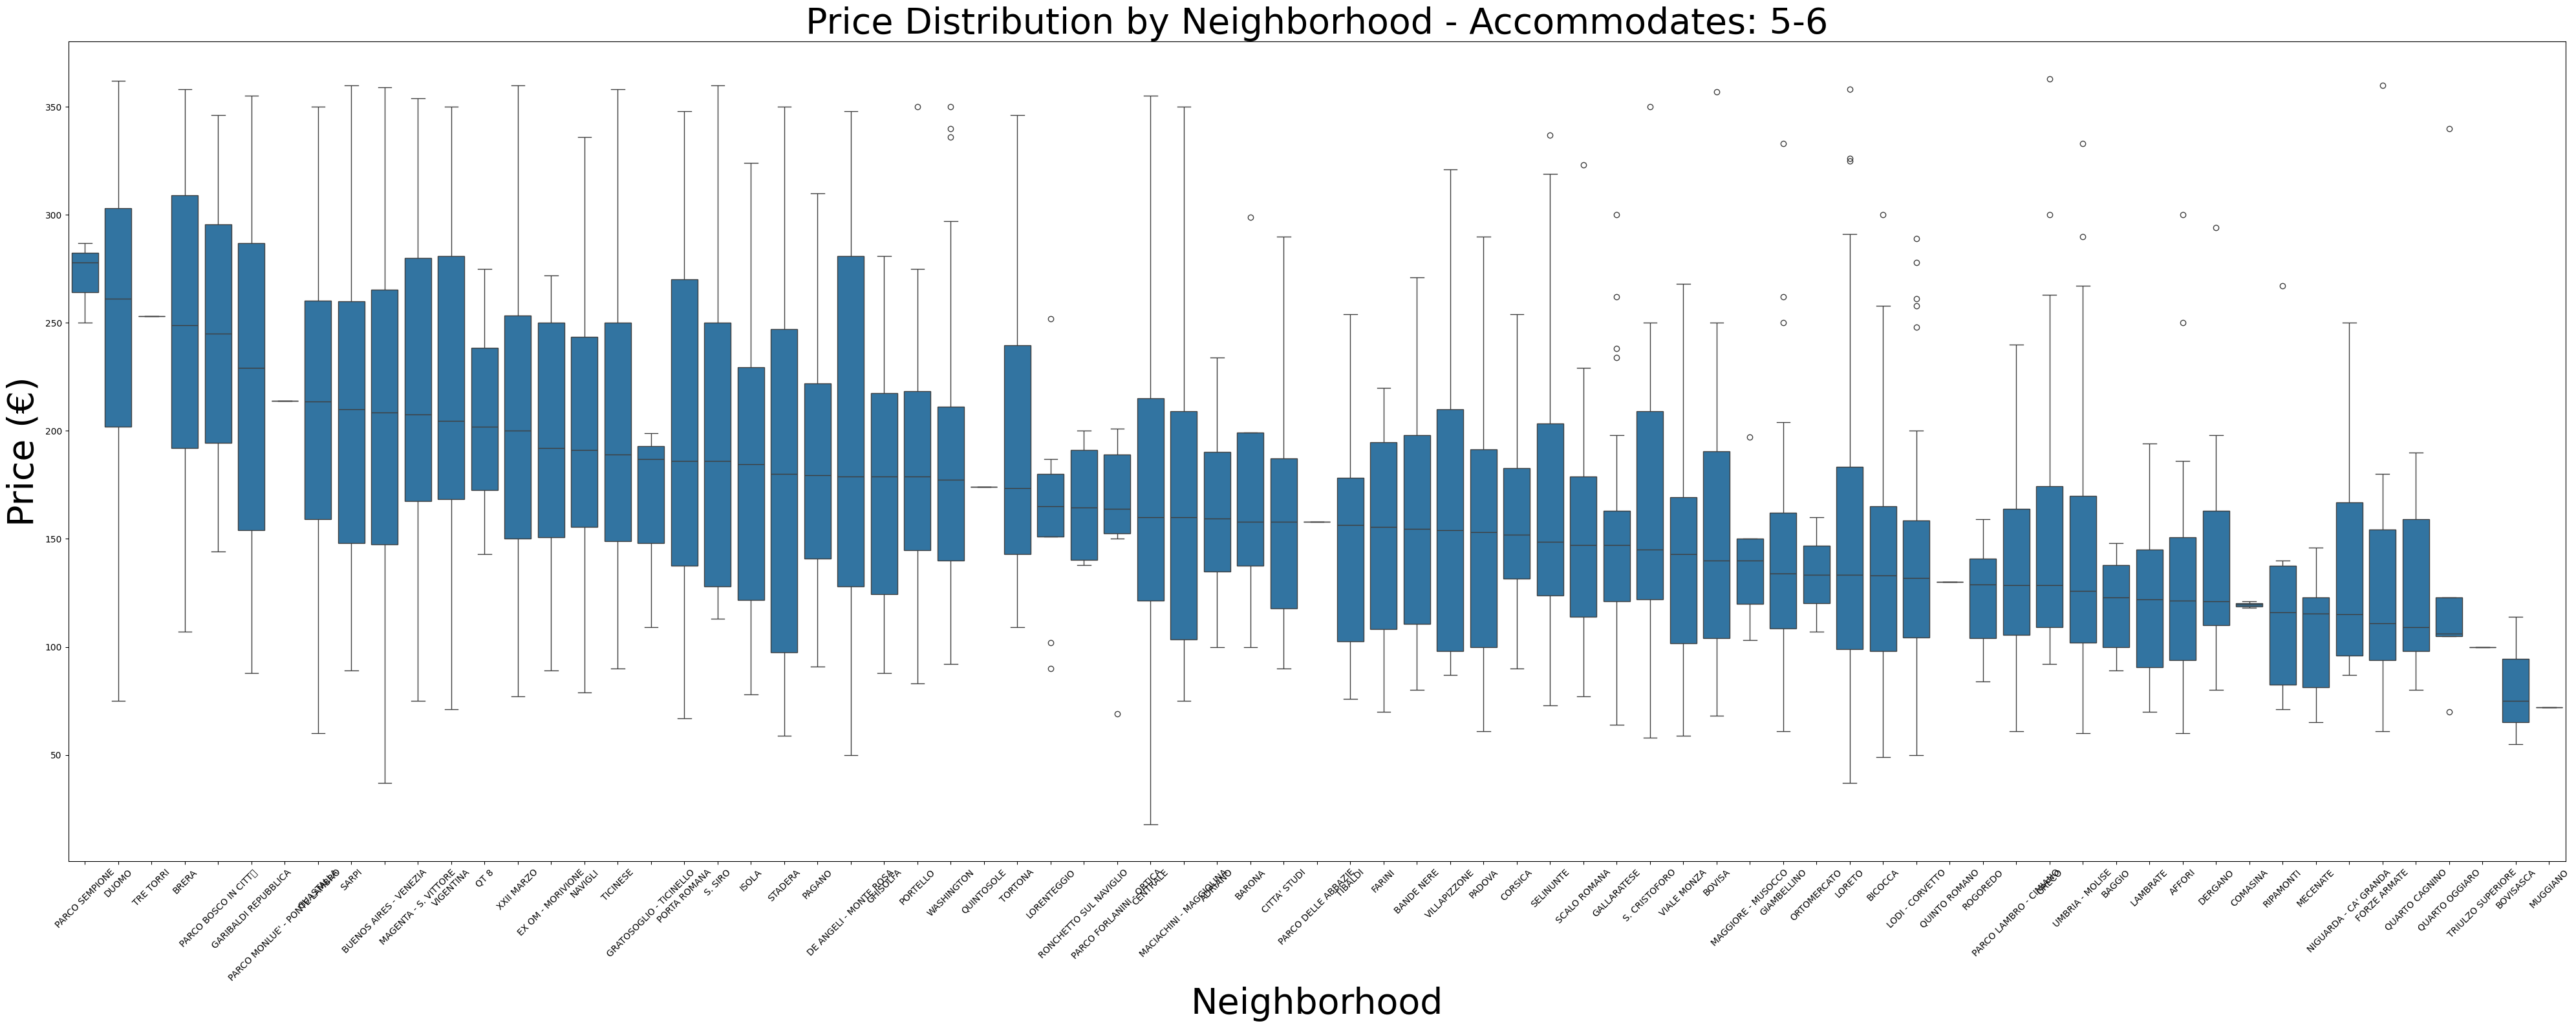

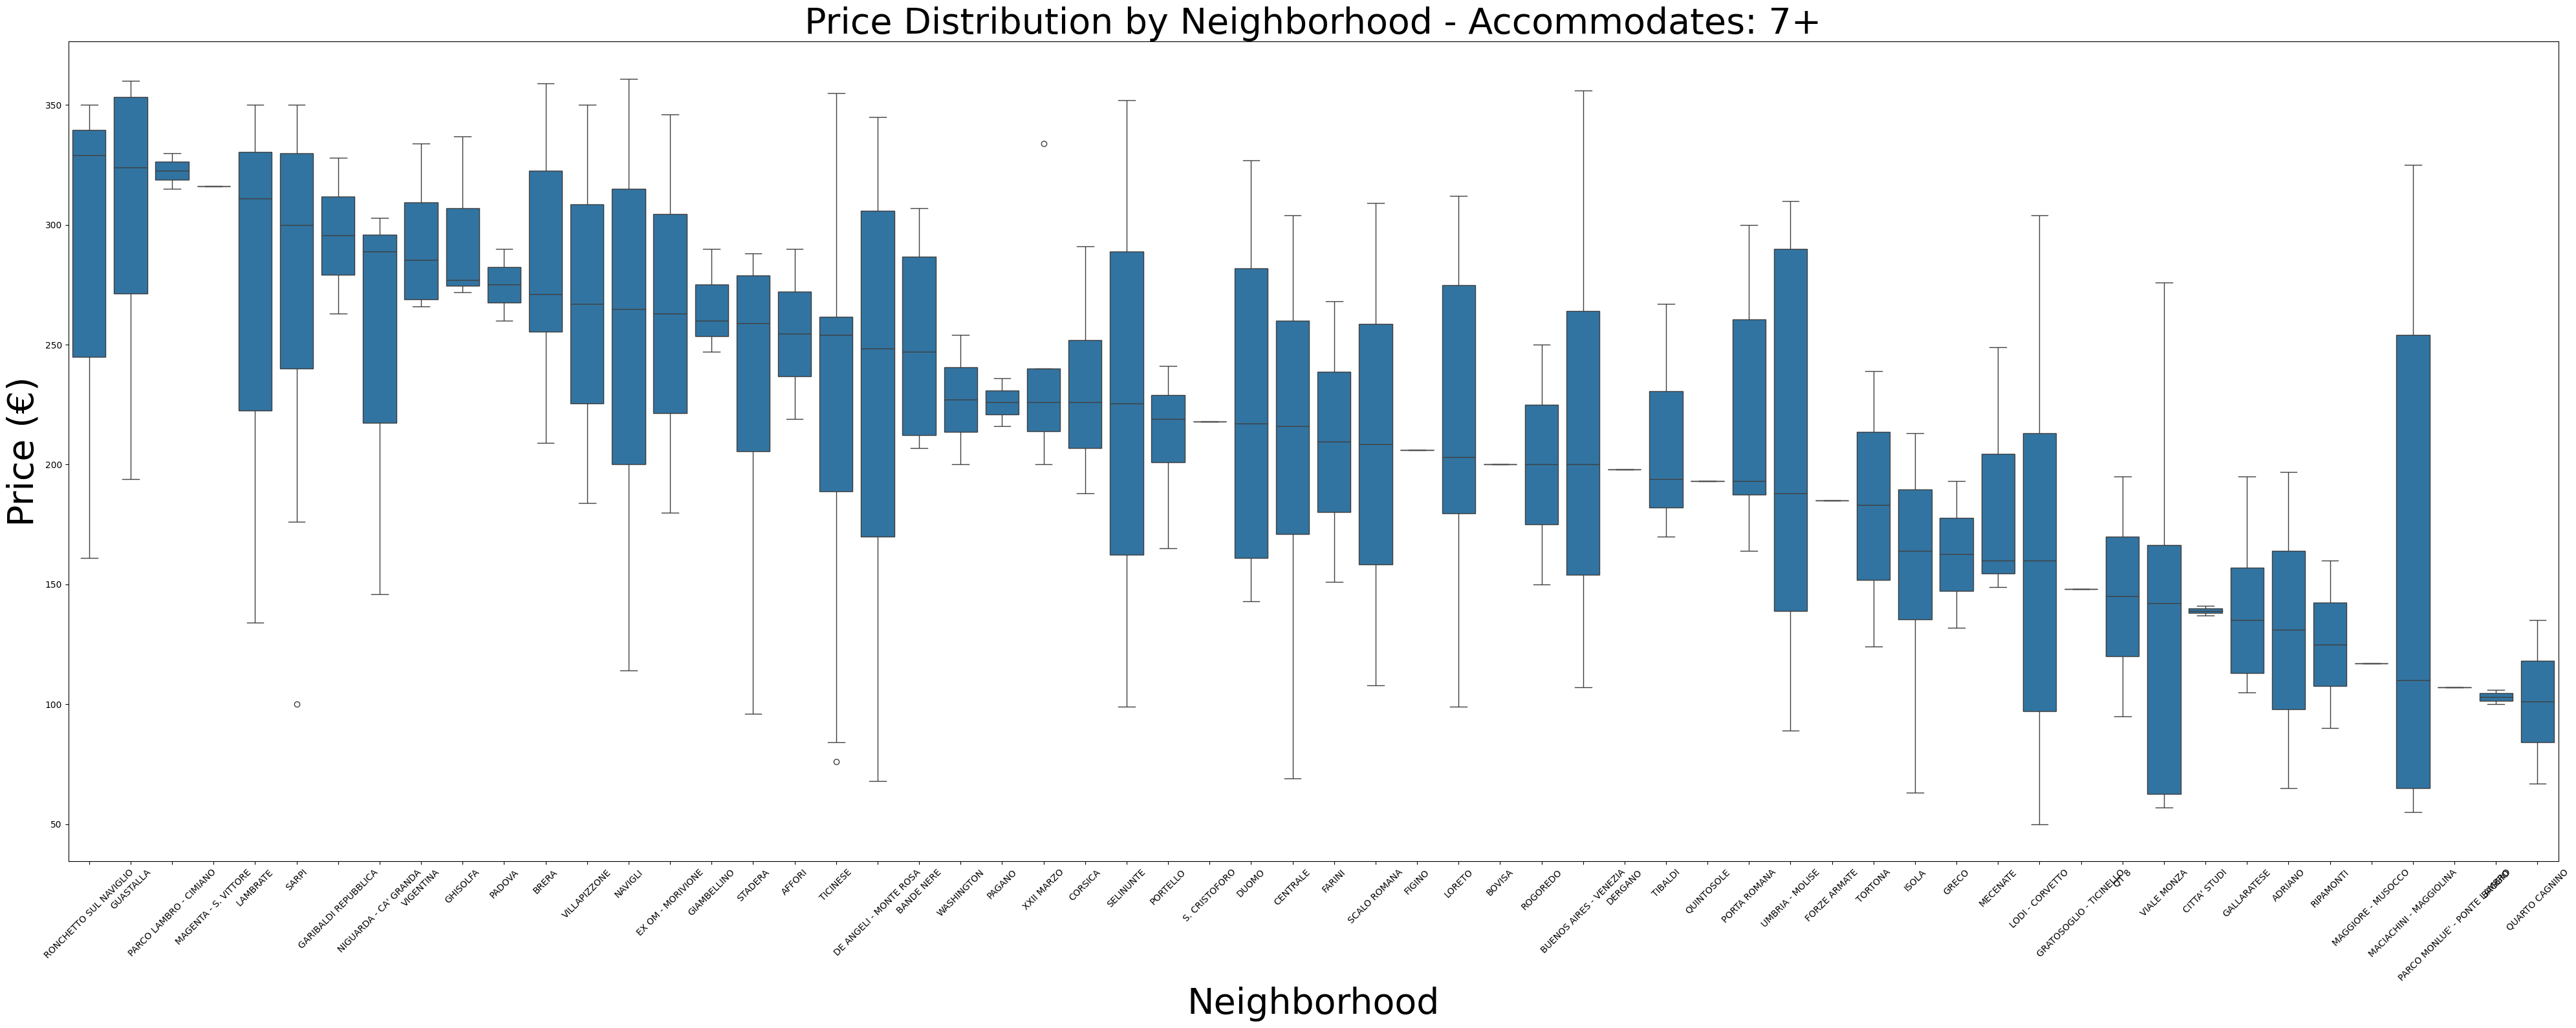

In [ ]:

df_price['accommodates'] = X['accommodates']

# Create the accommodates bins
def create_accommodates_bins(accommodates_values):
    bins = [0, 2, 4, 6, float('inf')]
    labels = ['1-2', '3-4', '5-6', '7+']
    return pd.cut(accommodates_values, bins=bins, labels=labels, include_lowest=True)

df_price['accommodates_bin'] = create_accommodates_bins(df_price['accommodates'])

# Convert to ordered categorical
df_price['accommodates_bin'] = pd.Categorical(
    df_price['accommodates_bin'], 
    categories=['1-2', '3-4', '5-6', '7+'], 
    ordered=True
)

# create boxplots for each accommodates bin
labels = ['1-2', '3-4', '5-6', '7+']

for bin_label in labels:
    subset = df_price[df_price['accommodates_bin'] == bin_label]
    
    if len(subset) == 0:  # Skip if no data for this bin
        print(f"No data for accommodates bin: {bin_label}")
        continue
    
    # Calculate neighborhood order by median price (most expensive first)
    quartiere_order = subset.groupby("quartiere")["price"].median().sort_values(ascending=False).index

    plt.figure(figsize=(40, 16))
    sns.boxplot(data=subset, x="quartiere", y="price", order=quartiere_order)
    plt.title(f"Price Distribution by Neighborhood - Accommodates: {bin_label}", fontsize=40)
    plt.xlabel("Neighborhood", fontsize=40)
    plt.ylabel("Price (€)", fontsize=40)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

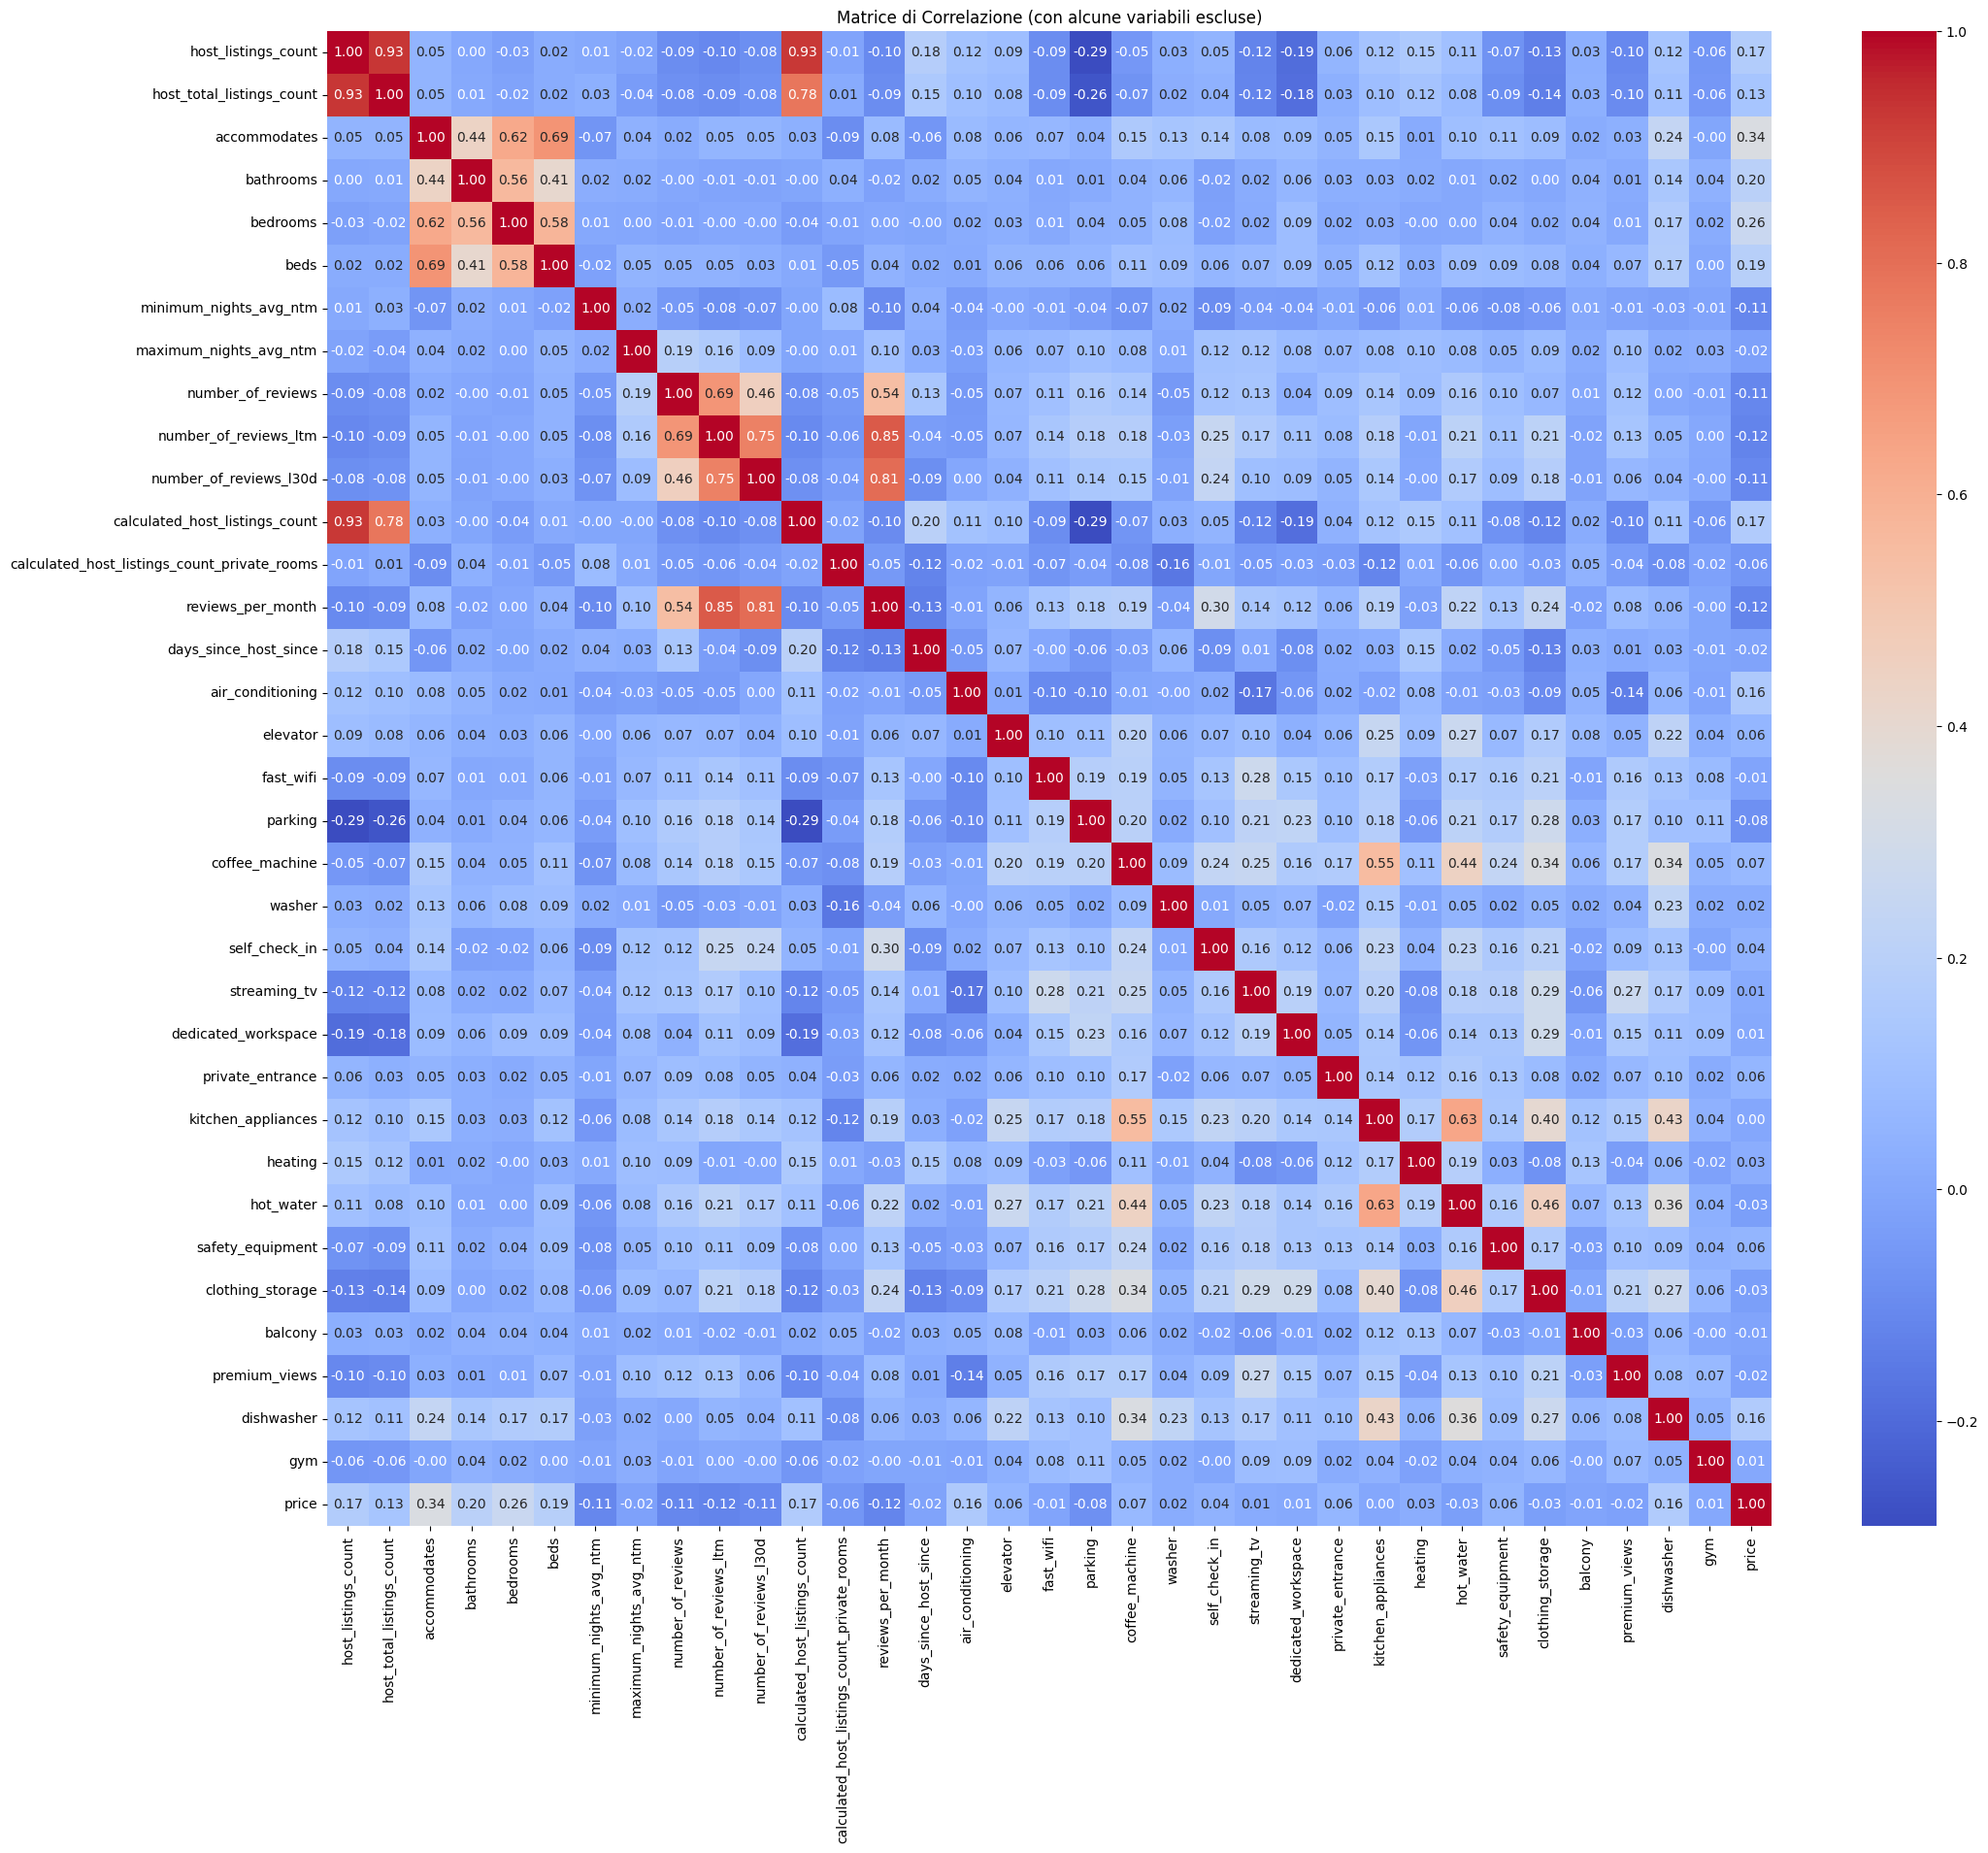

In [ ]:
# Lista delle colonne da escludere
excluded_cols = ["id", "latitude", "longitude"] 

# Crea una copia del DataFrame numerico
df_corr = df[num_cols].copy()

# Aggiungi la colonna 'price'
df_corr["price"] = y

# Elimina le colonne indesiderate
df_corr.drop(columns=excluded_cols, inplace=True)

# Calcola la matrice di correlazione
corr_matrix = df_corr.corr()

# Visualizza l'heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di Correlazione (con alcune variabili escluse)")
plt.show()

# Correlation Matrix Analysis

1. **High correlations among accommodation size variables**  
   - Variables like `accommodates`, `bedrooms`, and `beds` show strong correlations (some > 0.9). This is expected, as larger listings with more bedrooms tend to have more beds and accommodate more guests.

2. **Strong interdependence among review scores**  
   - Columns such as `number of reviews`, `number of reviews l30d`, `number of reviews ltm` and  `reviews per month` are highly correlated (often > 0.6). Makes sense since it probably cumulates.


3. **Relationship between price and other metrics**  
   - `price` is moderately correlated with `accommodates`, `bedrooms`, and `bathrooms` (correlation coefficient between 0.2 and 0.3), indicating that larger listings or those with more bathrooms tend to be more expensive.  

5. **Number of reviews and review scores**  
   - Variables like `number_of_reviews`, `number_of_reviews_ltm`, and `reviews_per_month` are positively correlated.  
   - There is also a slight negative correlation with some review scores: as the number of reviews increases, the average ratings may decrease slightly, possibly due to a “regression to the mean” effect.

6. **Negative correlation between the number of listings per host and review scores**  
   - `calculated_host_listings_count` shows a weak/medium negative correlation (around -0.3) with review scores. Hosts managing multiple listings may provide a more "business-oriented" rather than personalized experience, which could result in slightly lower ratings on average.

7. **Other considerations**  
   - Some binary variables, such as `description_present`, show no significant correlations with other features, suggesting a negligible impact on most key metrics.  
   - Overall, the results confirm expected correlations (e.g., between accommodation size variables and review scores) while highlighting interesting insights, such as the need to control multicollinearity and the importance of key variables (`accommodates`, `beds`, `bedrooms`) in subsequent modeling stages.
